# Introduction
This project will involve forecasting time series data related to average real estate prices in various zipcodes in order to answer the client's question: "What are the top 5 zipcodes for us to invest in?" This question is a bit vague, and will require some domain knowledge to answer. To approach this project, a CRISP-DM workflow will be followed. This notebook contains all work related to domain understanding and data understanding and preparation, as well as an analysis to find the top 5 performing zip codes. The modeling notebook continues on from that point.<br>
<br>
#### Outline:
[Business Understanding](#business_understanding)<br>
[Data Understanding](#data_understanding)<br>
[Data Preparation](#data_preparation)<br>
>[Finding Best Zip Codes](#finding_zipcodes)<br>
>[Looking at the whole market](#whole_market)<br>

<a id='business_understanding'></a>
# Business Understanding:
A couple things to immediately note about the question at hand:
<ol>
    <li>
        Whether the client is looking at investment in residential/commercial real estate (or both) is not established. Taking a look at the <a href='https://www.zillow.com/research/data/'>Zillow Research Page</a>, from which the data is sourced, reveals that the prices are in reference to residential properties. This is valuable to know, as it narrows the scope of consideration for market forces that might be in effect at any given time, and removes possibility of inconsistences of market type among the zipcodes.</li>
    <li>        
The time horizon for these investments is not defined. Shorter-term investments that could bring faster returns typically have more risk involved due to price volatility. Less volatile markets with stable growth are typically good targets for longer term investment. Diversification is generally accepted to be a good strategy in any investment portfolio, so it may be wise to consider some split between these two strategies. With real estate, one could assume that the holding period of the assets would be longer than, say, with stock investment, since real estate is less liquid. This might mean that a short holding period may be more like a year, and a longer holding period around 5 or even 10 years or more. More exposure to the data will reveal some strategic insights. It is also important to note that long-term real-estate investments can be leased in the short-term. Although it is not established whether the client is a landlord or property management company, these services can be provided by third parties, so for any type of investor holding real estate for years at a time, this is a good profit strategy. In all, logic would suggest that the strategy should be investing in properties which have strong expected growth over a time horizon, and leasing the property during that time horizon.</li></ol>
<br>
 Although the <a href='https://www.investopedia.com/articles/basics/04/022004.asp'>Efficient Market Hypothesis</a>, which states that market prices reflect all current available knowledge affecting the investment, has been shown to be demonstrably false (as indicated by the level of diversity in the returns of individual investors in markets), it is not completely without merit or unworthy of consideration. Especially when dealing with average prices for real estate in a region, such as this dataset, one can expect that a fair deal of knowledge about the future expectations for the real estate of that region is already factored into the averaged market price seen. Further, depending on the number of zipcodes in the dataset, doing individualized research to understand fundamental developments occuring in each may be unfeasible. However, if the list is narrowed down to a few, further investigation may be appropriate.<br>
 <br>
 Since models will have a range of values within the confidence interval, the low side may or may not be higher than the initial investment, a good way to narrow down the pool of zipcodes to consider might involve using the lower end of the confidence interval at a projection period of 5 years out, and seeing if it is higher than the initial investment, therefore showing good confidence that in a worst case scenario, the investor would not be likely to LOSE any money on the investment. Also, any losses may be offset by leasing the properties over the course of the investment period.<br>
 <br>
 Another filtering method that may be employed would be to find the average monthly return of each zipcode, and focus on those zipcodes which consistently outperformed in repeated sampling of random time windows. Since the data spans across the Great Recession, this would also indicate which zipcodes had real estate which was more resilient to the crisis, further justifying investor confidence.

<a id='data_understanding'></a>
# Data Understanding:
- The data to be used for this project has been made available in a .csv file 'zillow_data.csv' contained in this repository. The data is in Wide Format, meaning that the dates for the time series are the headers of columns. This means that the data will have to be melted using pandas in order to get it into Long Format, which will be necessary for modeling the time series.
- Further data about the zip codes may later be obtained from the internet, depending on the project's needs, after the list of potential investments has been considerably narrowed down.

In [2]:
# Importing the necessary libraries
from IPython.display import display
import matplotlib.pyplot as plt
from functions import my_functions as mf
import numpy as np
from operator import itemgetter
import pandas as pd
from scipy import stats
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [3]:
%load_ext autoreload
%autoreload 1
%aimport my_functions

In [4]:
# Plot styling
plt.style.use('ggplot')
from jupyterthemes import jtplot
jtplot.style()

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 7

In [6]:
pd.plotting.register_matplotlib_converters()

## Loading DataFrame and Initial Feature Inspection

In [8]:
# Getting a look at the raw data
df = pd.read_csv('data/zillow_data.csv')
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [196]:
import dataframe_image as di

In [10]:
#di.export(df.iloc[:5], 'images/df_head1.png', max_cols = 15)

A question to answer immediately is whether the RegionID or RegionName represents the zip code of a region. A few quick google searches reveal that the RegionName column contains the zip codes.

In [11]:
# Getting the number of rows and columns
df.info(())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [12]:
# We can see that there are a lot of rows, 14723, in the dataset.
# Checking to see if there is the same number of unique zip codes (RegionName)
df.RegionName.nunique()

14723

In [13]:
# We see that there are 14723 unique zip codes in the database. For clarity, I will rename
# the RegionName column to 'zipcode':
df.rename(columns={'RegionName':'zipcode'}, inplace=True)
df.head(15)

RegionID  zipcode           City State              Metro     CountyName  \
0      84654    60657        Chicago    IL            Chicago           Cook   
1      90668    75070       McKinney    TX  Dallas-Fort Worth         Collin   
2      91982    77494           Katy    TX            Houston         Harris   
3      84616    60614        Chicago    IL            Chicago           Cook   
4      93144    79936        El Paso    TX            El Paso        El Paso   
5      91733    77084        Houston    TX            Houston         Harris   
6      61807    10467       New York    NY           New York          Bronx   
7      84640    60640        Chicago    IL            Chicago           Cook   
8      91940    77449           Katy    TX            Houston         Harris   
9      97564    94109  San Francisco    CA      San Francisco  San Francisco   
10     62037    11226       New York    NY           New York          Kings   
11     71831    32162   The Villages    FL       The Villages         Sumter   
12     62087    11375       New York    NY           New York         Queens   
13     62045    11235       New York    NY           New York          Kings   
14     74101    37013      Nashville    TN          Nashville       Davidson   

    SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0          1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1          2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2          3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3          4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4          5   77300.0   77300.0   77300.0  ...   119100   119400   120000   
5          6   95000.0   95200.0   95400.0  ...   157900   158700   160200   
6          7  152900.0  152700.0  152600.0  ...   394400   400000   407300   
7          8  216500.0  216700.0  216900.0  ...   798000   787100   776100   
8          9   95400.0   95600.0   95800.0  ...   166800   167400   168400   
9         10  766000.0  771100.0  776500.0  ...  3767700  3763900  3775000   
10        11  162000.0  162300.0  162600.0  ...   860200   851000   853900   
11        12  101000.0  100700.0  100400.0  ...   249900   250400   249900   
12        13  252400.0  251800.0  251400.0  ...  1022600  1033700  1048600   
13        14  190500.0  191000.0  191500.0  ...   767300   777300   788800   
14        15  112400.0  112700.0  113000.0  ...   193000   194900   196600   

    2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0   1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1    314100   315000   316600   318100   319600   321100   321800  
2    320400   320800   321200   321200   323000   326900   329900  
3   1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4    120300   120300   120300   120300   120500   121000   121500  
5    161900   162800   162800   162800   162900   163500   164300  
6    411600   413200   414300   413900   411400   413200   417900  
7    774900   777900   777900   778500   780500   782800   782800  
8    169600   170900   172300   173300   174200   175400   176200  
9   3799700  3793900  3778700  3770800  3763100  3779800  3813500  
10   870000   885100   887800   890500   901700   930700   963200  
11   248700   247500   247100   246800   247500   249800   251800  
12  1066400  1081200  1088800  1092700  1089500  1084000  1084600  
13   793900   796000   799700   806600   810600   813400   816200  
14   198800   201300   203800   205900   207600   210000   211900  

[15 rows x 272 columns]

In [14]:
# It appears the SizeRank column is in ascending order, no description of this column is given
df.SizeRank

0            1
1            2
2            3
3            4
4            5
         ...  
14718    14719
14719    14720
14720    14721
14721    14722
14722    14723
Name: SizeRank, Length: 14723, dtype: int64

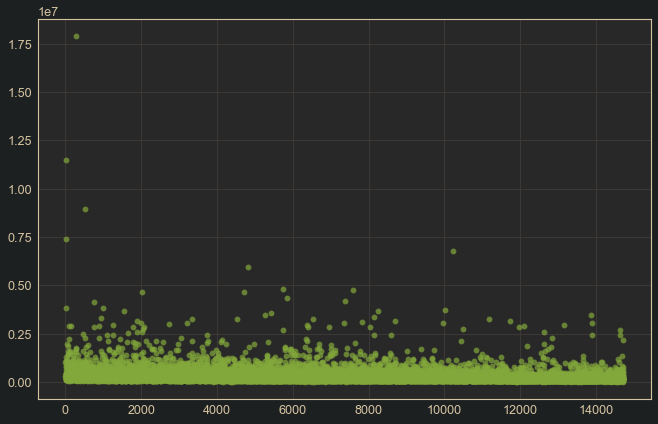

In [15]:
# Does SizeRank have any correlation to most recent prices?
plt.figure(figsize=(11,7))
plt.scatter(df.SizeRank, df['2018-04'], alpha=0.7);

In [16]:
# Althought the largest outliers in most recent prices fall in the earlier size ranks,
# there does not appear to be any significant correlation beyond that. This feature is probably
# not valuable.

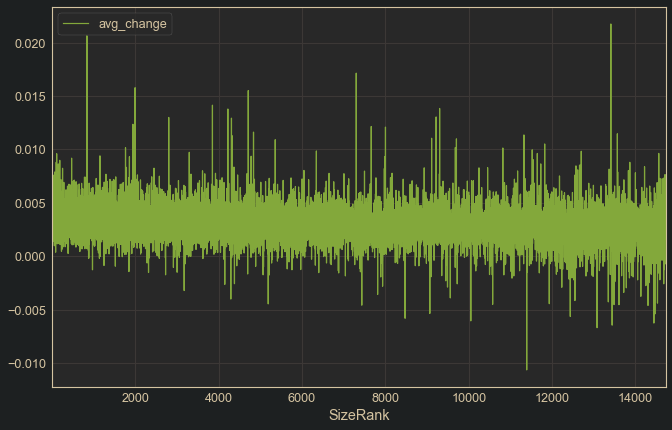

In [17]:
# I would like to see another relationship, that between SizeRank and the average monthly change
# of a zipcode over the whole time period
pct_change = df.set_index('SizeRank').drop(columns=['City', 
                                                   'State', 
                                                   'Metro', 
                                                   'CountyName', 
                                                   'RegionID',
                                                   'zipcode',]).T.pct_change()
avg_change = pd.DataFrame(pct_change.mean(), columns=['avg_change'])
avg_change.plot()

In [18]:
avg_change.head()

avg_change
SizeRank            
1           0.004295
2           0.001215
3           0.001757
4           0.003682
5           0.001728

In [19]:
# Adding SizeRank back as a column for compatibility with functions
avg_change = avg_change.reset_index()
avg_change.head()

SizeRank  avg_change
0         1    0.004295
1         2    0.001215
2         3    0.001757
3         4    0.003682
4         5    0.001728

In [20]:
# A look at the pearson correlation score for the two columns
avg_change.corr()

SizeRank  avg_change
SizeRank    1.000000   -0.124774
avg_change -0.124774    1.000000

Linear Regression for avg_change~SizeRank


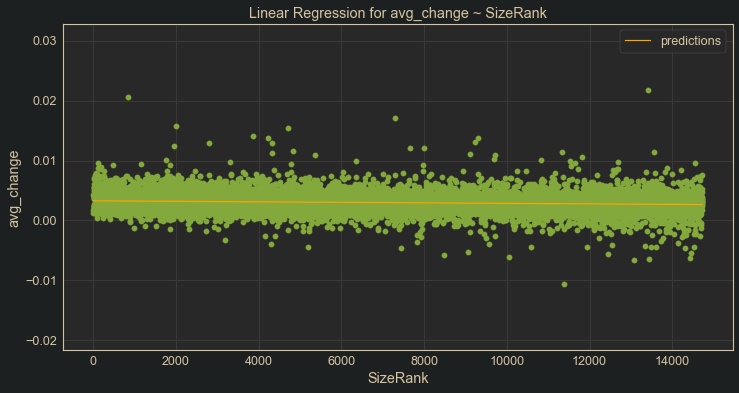

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_change   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     232.8
Date:                Thu, 10 Sep 2020   Prob (F-statistic):           3.65e-52
Time:                        17:30:13   Log-Likelihood:                 75316.
No. Observations:               14723   AIC:                        -1.506e+05
Df Residuals:                   14721   BIC:                        -1.506e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0033   2.39e-05    136.700      0.000       0.003       0.003
SizeRank   -4.298e-08   2.82e-09    -15.258      0.000   -4.85e-08   -3.75e-08
==============================================================================
Omnibus:                     3405.502   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52557.288
Skew:                           0.691   Prob(JB):                         0.00
Kurtosis:                      12.152   Cond. No.                     1.70e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Test for homoscedasticity of residuals:


F_statistic      p_value
Goldfeld-Quandt     1.55542  1.12559e-71

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 0.496387 
 0.937573 
 
 
 p-value 
 0.000000 
 0.000000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 114.871991 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 residuals 
 
 
 
 
 Statistic 
 52557.287540 
 
 
 p-value 
 0.000000 
 
 
 Skew 
 0.691120 
 
 
 Kurtosis 
 12.152223

Skew: 0.691120172619765
Kurtosis: 9.152222715093057


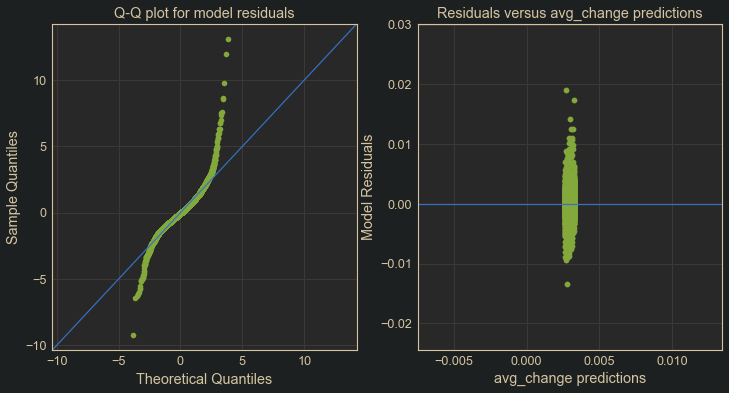

In [21]:
# There does appear to be a small amount of negative correlation between the SizeRank and the
# overall average monthly change of a zipcode. Let's test this relationship further with a
# linear regression.
mf.do_a_linreg(avg_change, 'SizeRank', 'avg_change')

In the above regression, the coefficient for the SizeRank feature's influence on a zipcode's overall average monthly return, though apparently significant, is very small. Further, the assumptions of the regression were not met, as the null hypothesis of the Goldfeld-Quandt of homoscedastic residuals is rejected, and the null hypothesis of normal residuals is rejected by all of the tests of normality. The R-squared is woeful anyhow. I will assume this feature is not valuable, and ignore it from here.

<a id='data_preparation'></a>
# Data Preparation:

In [22]:
# Dropping the SizeRank column, as well as the RegionID
df.drop(columns=['RegionID', 'SizeRank'], inplace=True)

In [23]:
# Melting dataframe to convert into Long Format
df2 = pd.melt(df, id_vars=['zipcode', 'City', 'State', 'Metro', 'CountyName'], var_name='date')
df2.head()

zipcode      City State              Metro CountyName     date     value
0    60657   Chicago    IL            Chicago       Cook  1996-04  334200.0
1    75070  McKinney    TX  Dallas-Fort Worth     Collin  1996-04  235700.0
2    77494      Katy    TX            Houston     Harris  1996-04  210400.0
3    60614   Chicago    IL            Chicago       Cook  1996-04  498100.0
4    79936   El Paso    TX            El Paso    El Paso  1996-04   77300.0

In [24]:
#di.export(df2.iloc[:5], 'images/df2head1.png')

In [25]:
# We can see that the unpivoted dataframe is quite long, with nearly 4 million rows
len(df2)

3901595

In [26]:
# Converting 'date' column to datetime format
df2.date = pd.to_datetime(df2.date, format='%Y-%m')
df2.date

0         1996-04-01
1         1996-04-01
2         1996-04-01
3         1996-04-01
4         1996-04-01
             ...    
3901590   2018-04-01
3901591   2018-04-01
3901592   2018-04-01
3901593   2018-04-01
3901594   2018-04-01
Name: date, Length: 3901595, dtype: datetime64[ns]

In [27]:
# checking 'value' column for missing data:
df2.value.isna().sum()

156891

In [28]:
# There are many missing values, but I will leave them in place for now

# Grouping the data by zipcode
groups = df2.groupby('zipcode')
len(groups)

14723

1001
1002
1005
1007
1008
1010


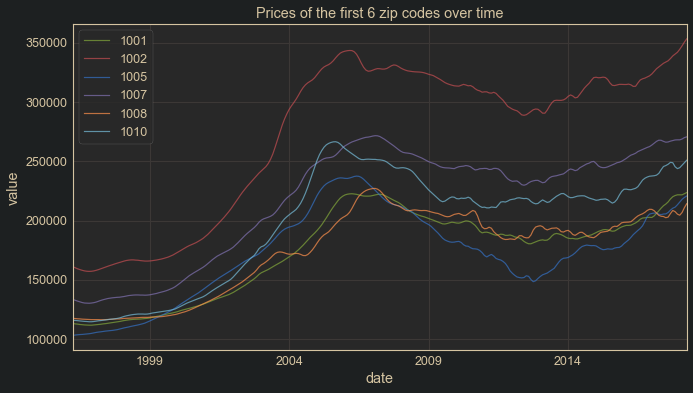

In [29]:
# A quick look at the first 6 zipcodes:
for i, (name, group) in enumerate(groups):
    print(name)
    group.set_index('date').value.plot(figsize=(11,6), alpha=0.7, label=name)
    if i >= 5:
        break
        
plt.ylabel('value')
plt.title('Prices of the first 6 zip codes over time')
plt.legend();

Above we can start to see that not all zipcodes are growing at the same overall rate, and that the 2007 crisis had greater or more long lasting effects on certain ones. For instance, zipcode 01008 and 01001 both had less of a decline post-2007 than zipcode 01005, but they have all seemed to recover to around their pre-crash levels. Earlier, we saw that the average among all zip codes is higher than it was before the crash, meaning some zipcodes have been growing better than others since the low point around 2013, certainly better than the ones above, which all are pretty close to breaking even with their previous highs.

<a id='finding_zipcodes'></a>
## Finding outperforming zip codes
Now to conduct an analysis of the data to find the top performing zip codes. The objective is to find zip codes which showed superior growth as well as resilience during the crash. Zip codes for which recent growth is slow will be less favored.

In [30]:
# First using percent changes
pct_change = df.set_index('zipcode').drop(columns=['City', 
                                                   'State', 
                                                   'Metro', 
                                                   'CountyName'
                                                  ]).T.pct_change()

In [31]:
pct_change.head()

zipcode     60657     75070     77494     60614     79936     77084     10467  \
1996-04       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1996-05  0.003591  0.005091  0.008555  0.005621  0.000000  0.002105 -0.001308   
1996-06  0.003280 -0.000844  0.000000  0.004392  0.000000  0.002101 -0.000655   
1996-07  0.003269 -0.005492 -0.007069  0.002982  0.000000  0.003145 -0.001311   
1996-08  0.002666 -0.008921 -0.011391  0.001784  0.001294  0.002090 -0.000656   

zipcode     60640     77449     94109  ...     3765      84781     12429  \
1996-04       NaN       NaN       NaN  ...       NaN       NaN       NaN   
1996-05  0.000924  0.002096  0.006658  ... -0.008663  0.002943  0.000000   
1996-06  0.000923  0.002092  0.007003  ... -0.008739  0.002201 -0.001277   
1996-07  0.000461  0.003132  0.006954  ... -0.010076  0.002196  0.000000   
1996-08  0.000461  0.003122  0.006906  ... -0.008906  0.001461 -0.001279   

zipcode     97028     12720     1338      3293      40404     81225     89155  
1996-04       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1996-05  0.002937  0.001600 -0.003171 -0.002157  0.003503  0.006803 -0.000567  
1996-06  0.001464  0.001597 -0.003181 -0.001081  0.003490  0.006757 -0.001134  
1996-07  0.000000  0.000000 -0.003191 -0.002165  0.003478  0.006711 -0.000568  
1996-08 -0.000731  0.000000 -0.003202 -0.001085  0.005199  0.006667 -0.000568  

[5 rows x 14723 columns]

Median for 60657: 0.004016387138366273
Mean for 60657: 0.0042950361785796054
Normality Test Results for [60657]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 60657 
 Statistic 
 4.952419e-01 
 0.988272 
 
 
 p-value 
 2.559368e-60 
 0.030556 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 60657 
 0.970426 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 60657 
 
 
 
 
 Statistic 
 1.042787 
 
 
 p-value 
 0.593693 
 
 
 Skew 
 -0.078841 
 
 
 Kurtosis 
 2.735547

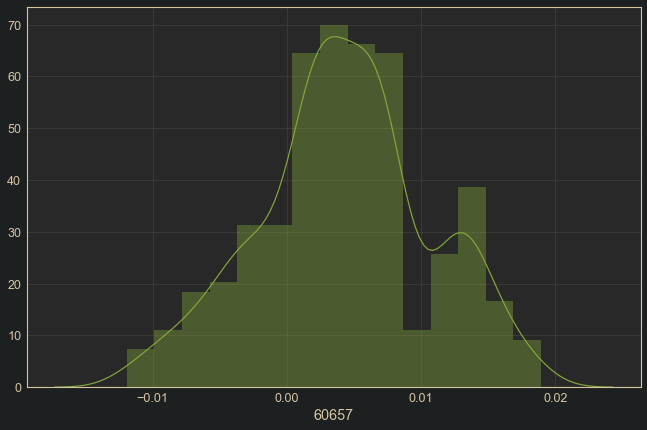

Median for 75070: 0.002254961175804371
Mean for 75070: 0.0012151485394771924
Normality Test Results for [75070]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 75070 
 Statistic 
 4.897961e-01 
 9.421729e-01 
 
 
 p-value 
 6.380644e-59 
 1.105654e-08 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 75070 
 5.644502 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 75070 
 
 
 
 
 Statistic 
 4.307768e+01 
 
 
 p-value 
 4.423863e-10 
 
 
 Skew 
 -5.530765e-01 
 
 
 Kurtosis 
 4.640908e+00

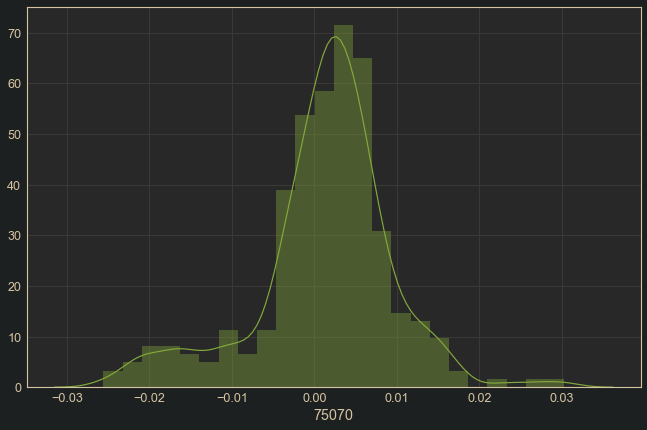

Median for 77494: 0.0013373421057769619
Mean for 77494: 0.00175682453435862
Normality Test Results for [77494]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 77494 
 Statistic 
 4.886697e-01 
 9.440606e-01 
 
 
 p-value 
 1.233816e-58 
 1.722436e-08 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 77494 
 4.750811 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 77494 
 
 
 
 
 Statistic 
 4.542569e+01 
 
 
 p-value 
 1.367529e-10 
 
 
 Skew 
 6.968922e-02 
 
 
 Kurtosis 
 5.027358e+00

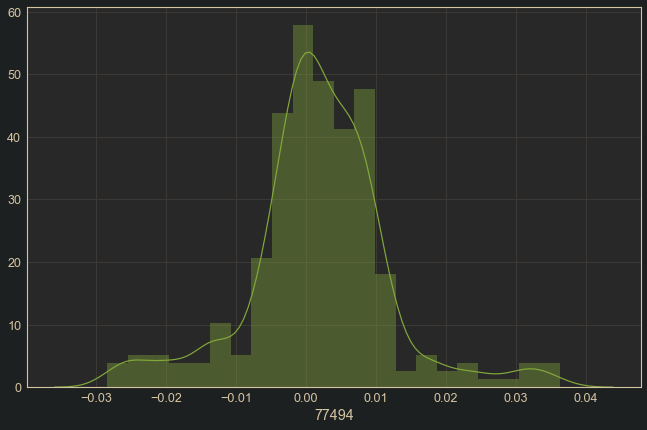

Median for 60614: 0.003648611561309134
Mean for 60614: 0.0036818024757118103
Normality Test Results for [60614]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 60614 
 Statistic 
 4.945085e-01 
 0.987546 
 
 
 p-value 
 3.957235e-60 
 0.022071 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 60614 
 0.888871 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 60614 
 
 
 
 
 Statistic 
 1.131290 
 
 
 p-value 
 0.567994 
 
 
 Skew 
 -0.154046 
 
 
 Kurtosis 
 2.910981

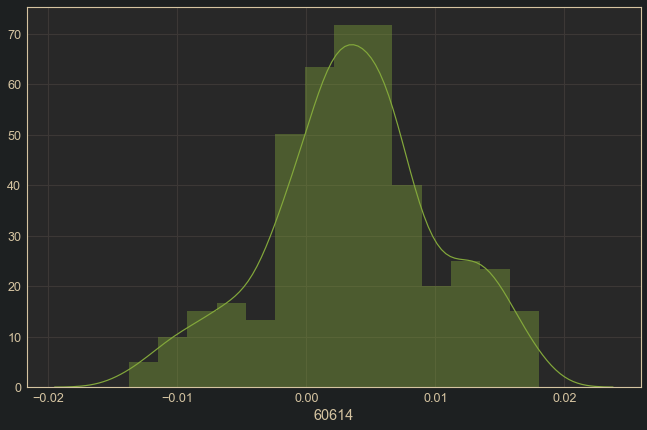

Median for 79936: 0.0012714809964918805
Mean for 79936: 0.001728273319979783
Normality Test Results for [79936]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 79936 
 Statistic 
 4.954825e-01 
 9.577079e-01 
 
 
 p-value 
 2.218038e-60 
 5.729984e-07 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 79936 
 3.097394 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 79936 
 
 
 
 
 Statistic 
 3.524575e+01 
 
 
 p-value 
 2.220667e-08 
 
 
 Skew 
 7.404179e-01 
 
 
 Kurtosis 
 4.005626e+00

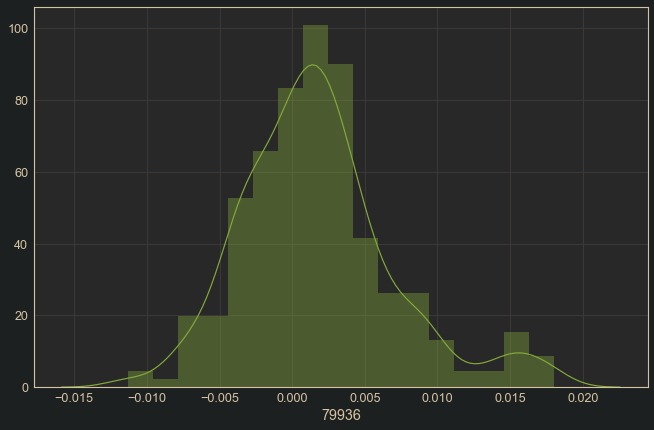

In [32]:
# Checking how normal the distributions are to determine if mean is a reliable statistic to use
for i in range(5):
    subset = pct_change.iloc[:, i]
    sns.distplot(subset.dropna())
    print("Median for {}: {}".format(subset.name, subset.median()))
    print("Mean for {}: {}".format(subset.name, subset.mean()))
    mf.check_normality(subset, [subset.name])
    plt.show()

In [33]:
# We can see that while some of the zipcodes have normally distributed percent changes,
# some do not, so mean may not be the best comparison, and median may be more robust.
# First, I'd like to see how the distributions of log returns look
log_rets = np.log(df.set_index('zipcode').drop(columns=['City', 
                                                   'State', 
                                                   'Metro', 
                                                   'CountyName'
                                                  ]).T).diff()
log_rets.head()

zipcode     60657     75070     77494     60614     79936     77084     10467  \
1996-04       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1996-05  0.003584  0.005078  0.008519  0.005606  0.000000  0.002103 -0.001309   
1996-06  0.003274 -0.000845  0.000000  0.004382  0.000000  0.002099 -0.000655   
1996-07  0.003264 -0.005507 -0.007094  0.002977  0.000000  0.003140 -0.001311   
1996-08  0.002662 -0.008961 -0.011456  0.001782  0.001293  0.002088 -0.000656   

zipcode     60640     77449     94109  ...     3765      84781     12429  \
1996-04       NaN       NaN       NaN  ...       NaN       NaN       NaN   
1996-05  0.000923  0.002094  0.006636  ... -0.008701  0.002939  0.000000   
1996-06  0.000923  0.002090  0.006979  ... -0.008777  0.002199 -0.001278   
1996-07  0.000461  0.003127  0.006930  ... -0.010127  0.002194  0.000000   
1996-08  0.000461  0.003117  0.006883  ... -0.008946  0.001460 -0.001280   

zipcode     97028     12720     1338      3293      40404     81225     89155  
1996-04       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1996-05  0.002933  0.001599 -0.003176 -0.002160  0.003497  0.006780 -0.000567  
1996-06  0.001463  0.001596 -0.003186 -0.001082  0.003484  0.006734 -0.001135  
1996-07  0.000000  0.000000 -0.003197 -0.002167  0.003472  0.006689 -0.000568  
1996-08 -0.000731  0.000000 -0.003207 -0.001085  0.005186  0.006645 -0.000568  

[5 rows x 14723 columns]

Median for 60657: 0.004008342975265755
Mean for 60657: 0.004265745529291026
Normality Test Results for [60657]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 60657 
 Statistic 
 4.952133e-01 
 0.988135 
 
 
 p-value 
 2.603280e-60 
 0.028736 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 60657 
 0.971525 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 60657 
 
 
 
 
 Statistic 
 1.129386 
 
 
 p-value 
 0.568535 
 
 
 Skew 
 -0.095309 
 
 
 Kurtosis 
 2.742442

Median for 75070: 0.00225241976995072
Mean for 75070: 0.0011794334265765088
Normality Test Results for [75070]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 75070 
 Statistic 
 4.896633e-01 
 9.404321e-01 
 
 
 p-value 
 6.897024e-59 
 7.403229e-09 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 75070 
 5.807307 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 75070 
 
 
 
 
 Statistic 
 4.543445e+01 
 
 
 p-value 
 1.361552e-10 
 
 
 Skew 
 -5.946513e-01 
 
 
 Kurtosis 
 4.648018e+00

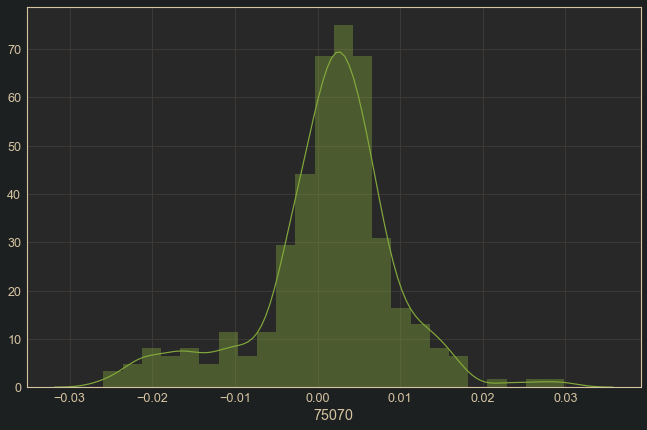

Median for 77494: 0.0013364486127782627
Mean for 77494: 0.0017037087021628033
Normality Test Results for [77494]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 77494 
 Statistic 
 4.885057e-01 
 9.443247e-01 
 
 
 p-value 
 1.357920e-58 
 1.833962e-08 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 77494 
 4.774342 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 77494 
 
 
 
 
 Statistic 
 4.384197e+01 
 
 
 p-value 
 3.018825e-10 
 
 
 Skew 
 8.646898e-03 
 
 
 Kurtosis 
 4.996330e+00

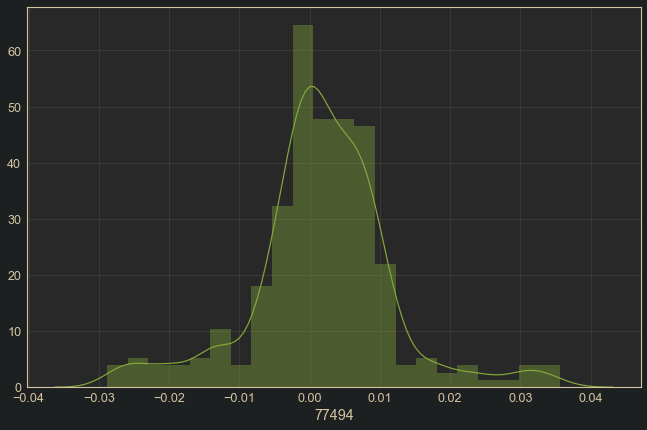

Median for 60614: 0.0036419698370986353
Mean for 60614: 0.003654124445246147
Normality Test Results for [60614]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 60614 
 Statistic 
 4.944704e-01 
 0.987231 
 
 
 p-value 
 4.047864e-60 
 0.019177 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 60614 
 0.901185 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 60614 
 
 
 
 
 Statistic 
 1.373603 
 
 
 p-value 
 0.503183 
 
 
 Skew 
 -0.172390 
 
 
 Kurtosis 
 2.922544

Median for 79936: 0.0012706733330958286
Mean for 79936: 0.0017129557090425275
Normality Test Results for [79936]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 79936 
 Statistic 
 4.954567e-01 
 9.591054e-01 
 
 
 p-value 
 2.252322e-60 
 8.491392e-07 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 79936 
 3.006986 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 79936 
 
 
 
 
 Statistic 
 3.334479e+01 
 
 
 p-value 
 5.744751e-08 
 
 
 Skew 
 7.210552e-01 
 
 
 Kurtosis 
 3.975532e+00

In [34]:
for i in range(5):
    subset = log_rets.iloc[:, i]
    sns.distplot(subset.dropna())
    print("Median for {}: {}".format(subset.name, subset.median()))
    print("Mean for {}: {}".format(subset.name, subset.mean()))
    mf.check_normality(subset, [subset.name])
    plt.show()

In [35]:
# We can see that this didn't help the normality of the zip codes. However, log returns are
# generally favored in the financial analysis world due to their mathematical properties. I
# will use them in this notebook.
# Because medians can sometimes ignore important information about outliers,
# and since the idea here is to find zipcodes which outperformed over time, AND were resilient
# during the crash, it may be better to allow the outliers to have a more weighted impact on
# central tendency so that highly negative values punish the scores.
# I will use both median and mean compare zipcode performance, and compare the two
medians = log_rets.median()
medians.head()

zipcode
60657    0.004008
75070    0.002252
77494    0.001336
60614    0.003642
79936    0.001271
dtype: float64

In [36]:
# Now I'd like to look at the 10 best performers
ten_best_median = medians.sort_values(ascending=False).iloc[:10]
ten_best_median

zipcode
27980    0.022908
30032    0.019264
49636    0.017914
80216    0.016801
89030    0.016425
30288    0.014718
43206    0.014418
94621    0.014299
29405    0.013560
89512    0.013498
dtype: float64

In [37]:
# And now to do the same with the means of log returns:
log_ret_means = log_rets.mean()
log_ret_means.head()

zipcode
60657    0.004266
75070    0.001179
77494    0.001704
60614    0.003654
79936    0.001713
dtype: float64

In [38]:
ten_best_means = log_ret_means.sort_values(ascending=False).iloc[:10]
ten_best_means

zipcode
27980    0.021365
30032    0.020352
80216    0.016964
89030    0.015623
94621    0.015365
43206    0.013883
89512    0.013676
30288    0.013591
95351    0.012892
32435    0.012830
dtype: float64

I now have a list of the ten best performing zip codes according to their median monthly returns and mean log returns over the time period. Some of the same zip codes appear on both lists, so these may make good contenders for inspection. I notice that zip code 49636 is entirely absent from the best performers according to mean, though it is third on the list according to median. This is probably demonstrating the effect of how medians give less weight to outliers. As stated before, the performance based on means may be better for this project, because if another housing market crash occurs, we want to know which zip codes were most resilient during the last one, which is reflected in their low outliers. 

zipcode      City State           Metro  CountyName       date  value
13409    27980  Hertford    NC  Elizabeth City  Perquimans 1996-04-01    NaN
28132    27980  Hertford    NC  Elizabeth City  Perquimans 1996-05-01    NaN
42855    27980  Hertford    NC  Elizabeth City  Perquimans 1996-06-01    NaN
57578    27980  Hertford    NC  Elizabeth City  Perquimans 1996-07-01    NaN
72301    27980  Hertford    NC  Elizabeth City  Perquimans 1996-08-01    NaN

zipcode            City State    Metro CountyName       date  value
842      30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-04-01    NaN
15565    30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-05-01    NaN
30288    30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-06-01    NaN
45011    30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-07-01    NaN
59734    30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-08-01    NaN

zipcode        City State          Metro CountyName       date  value
14341    49636  Glen Arbor    MI  Traverse City   Leelanau 1996-04-01    NaN
29064    49636  Glen Arbor    MI  Traverse City   Leelanau 1996-05-01    NaN
43787    49636  Glen Arbor    MI  Traverse City   Leelanau 1996-06-01    NaN
58510    49636  Glen Arbor    MI  Traverse City   Leelanau 1996-07-01    NaN
73233    49636  Glen Arbor    MI  Traverse City   Leelanau 1996-08-01    NaN

zipcode    City State   Metro CountyName       date  value
7302     80216  Denver    CO  Denver     Denver 1996-04-01    NaN
22025    80216  Denver    CO  Denver     Denver 1996-05-01    NaN
36748    80216  Denver    CO  Denver     Denver 1996-06-01    NaN
51471    80216  Denver    CO  Denver     Denver 1996-07-01    NaN
66194    80216  Denver    CO  Denver     Denver 1996-08-01    NaN

zipcode             City State      Metro CountyName       date  value
1998     89030  North Las Vegas    NV  Las Vegas      Clark 1996-04-01    NaN
16721    89030  North Las Vegas    NV  Las Vegas      Clark 1996-05-01    NaN
31444    89030  North Las Vegas    NV  Las Vegas      Clark 1996-06-01    NaN
46167    89030  North Las Vegas    NV  Las Vegas      Clark 1996-07-01    NaN
60890    89030  North Las Vegas    NV  Las Vegas      Clark 1996-08-01    NaN

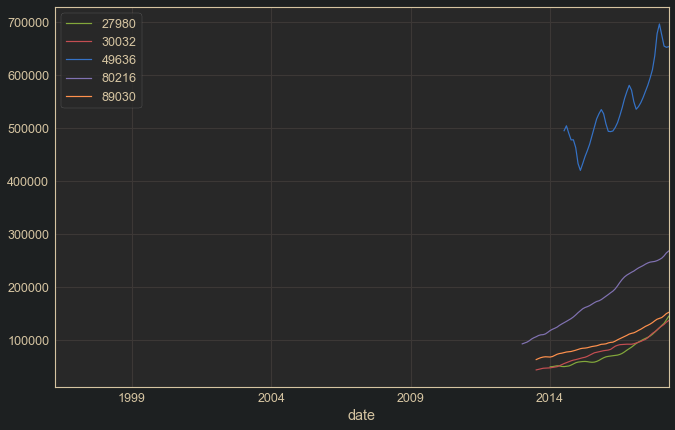

In [39]:
# I would like to compare the top five zipcodes from each list, to see if there is a visible
# difference in their performance
# First the top performers based on median:
for i in range(5):
    name = ten_best_median.index[i]
    zip_code = groups.get_group(name)
    display(zip_code.head())
    zip_code.set_index('date').value.plot(label=name)
plt.legend();

We can see that we've run into a problem related to NaN values. The zip codes above do not have data going back further than around 2014, which is after the recovery of the crash. This would explain why the central tendency of their returns would seem to outperform zip codes that had data during the crash.

zipcode      City State           Metro  CountyName       date  value
13409    27980  Hertford    NC  Elizabeth City  Perquimans 1996-04-01    NaN
28132    27980  Hertford    NC  Elizabeth City  Perquimans 1996-05-01    NaN
42855    27980  Hertford    NC  Elizabeth City  Perquimans 1996-06-01    NaN
57578    27980  Hertford    NC  Elizabeth City  Perquimans 1996-07-01    NaN
72301    27980  Hertford    NC  Elizabeth City  Perquimans 1996-08-01    NaN

zipcode            City State    Metro CountyName       date  value
842      30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-04-01    NaN
15565    30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-05-01    NaN
30288    30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-06-01    NaN
45011    30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-07-01    NaN
59734    30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-08-01    NaN

zipcode    City State   Metro CountyName       date  value
7302     80216  Denver    CO  Denver     Denver 1996-04-01    NaN
22025    80216  Denver    CO  Denver     Denver 1996-05-01    NaN
36748    80216  Denver    CO  Denver     Denver 1996-06-01    NaN
51471    80216  Denver    CO  Denver     Denver 1996-07-01    NaN
66194    80216  Denver    CO  Denver     Denver 1996-08-01    NaN

zipcode             City State      Metro CountyName       date  value
1998     89030  North Las Vegas    NV  Las Vegas      Clark 1996-04-01    NaN
16721    89030  North Las Vegas    NV  Las Vegas      Clark 1996-05-01    NaN
31444    89030  North Las Vegas    NV  Las Vegas      Clark 1996-06-01    NaN
46167    89030  North Las Vegas    NV  Las Vegas      Clark 1996-07-01    NaN
60890    89030  North Las Vegas    NV  Las Vegas      Clark 1996-08-01    NaN

zipcode     City State          Metro CountyName       date  value
4712     94621  Oakland    CA  San Francisco    Alameda 1996-04-01    NaN
19435    94621  Oakland    CA  San Francisco    Alameda 1996-05-01    NaN
34158    94621  Oakland    CA  San Francisco    Alameda 1996-06-01    NaN
48881    94621  Oakland    CA  San Francisco    Alameda 1996-07-01    NaN
63604    94621  Oakland    CA  San Francisco    Alameda 1996-08-01    NaN

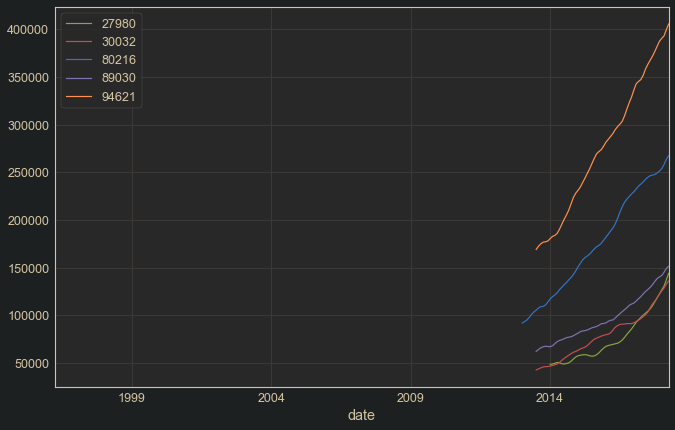

In [40]:
# Looking at the best performing based on mean
for i in range(5):
    name = ten_best_means.index[i]
    zip_code = groups.get_group(name)
    display(zip_code.head())
    zip_code.set_index('date').value.plot(label=name)
plt.legend();

Again, we are seeing the same problem. Zip codes which did not have data going back past around 2014 show better average performance than zip codes which had data during the crash.

In [41]:
# I need a list of zipcodes containing NaN values and count how many each has, because
# these could cause misrepresentations when combined with the rest of the zipcodes which have
# more historical data.
counts = {}
for name, group in groups:
    count = group.value.isna().sum()
    if count > 0:
        counts[name] = count

In [42]:
# Let's see how many zipcodes are missing values
len(counts)

1039

In [43]:
# I'm going to make panel data out of the data in case it comes in handy
index = pd.MultiIndex.from_frame(df2[['zipcode','date']].sort_values(['zipcode','date']))
panel = df2.reindex(index)

In [44]:
panel

zipcode City State Metro CountyName date  value
zipcode date                                                       
1001    1996-04-01      NaN  NaN   NaN   NaN        NaN  NaT    NaN
        1996-05-01      NaN  NaN   NaN   NaN        NaN  NaT    NaN
        1996-06-01      NaN  NaN   NaN   NaN        NaN  NaT    NaN
        1996-07-01      NaN  NaN   NaN   NaN        NaN  NaT    NaN
        1996-08-01      NaN  NaN   NaN   NaN        NaN  NaT    NaN
...                     ...  ...   ...   ...        ...  ...    ...
99901   2017-12-01      NaN  NaN   NaN   NaN        NaN  NaT    NaN
        2018-01-01      NaN  NaN   NaN   NaN        NaN  NaT    NaN
        2018-02-01      NaN  NaN   NaN   NaN        NaN  NaT    NaN
        2018-03-01      NaN  NaN   NaN   NaN        NaN  NaT    NaN
        2018-04-01      NaN  NaN   NaN   NaN        NaN  NaT    NaN

[3901595 rows x 7 columns]

In [45]:
# Checking number of dates in data
len(panel.loc[panel.index.levels[0][0]])

265

In [46]:
# Finding the number of dates in the data
for i, (name, group) in enumerate(groups):
    print("Number of dates in the data:", len(group.values))
    if i == 0:
        break

Number of dates in the data: 265


In [47]:
# We can see there are 1039 zip codes for which there is incomplete data over the time frame
# This is not a huge amount, but it does add a bit of complexity when comparing the performance
# of zip codes.
# Let's see how many values are missing from each of these zip codes, keeping in mind that
# there are 265 dates in total
N = 2000
res = dict(sorted(counts.items(), key = itemgetter(1), reverse = True)[:N]) 
for k, v in res.items():
    print(k, v)

2116 219
4009 219
16625 219
19954 219
22625 219
28039 219
28088 219
31527 219
32435 219
35759 219
35760 219
35810 219
35816 219
35824 219
39202 219
39216 219
43406 219
43443 219
43450 219
43466 219
43619 219
44491 219
45872 219
46320 219
46327 219
47336 219
47371 219
47373 219
47512 219
48157 219
49245 219
49253 219
49636 219
49950 219
53015 219
54230 219
56441 219
62215 219
62216 219
62440 219
62870 219
62882 219
62922 219
65259 219
66739 219
67544 219
68730 219
70431 219
70515 219
70647 219
72718 219
73173 219
74857 219
97435 219
97467 219
97499 219
10456 213
11749 213
12428 213
12458 213
13797 213
15943 213
21225 213
27980 213
29405 213
30288 213
32764 213
35773 213
35806 213
37184 213
38858 213
38862 213
38868 213
43013 213
43206 213
43211 213
43219 213
43569 213
44411 213
44449 213
49284 213
49799 213
50233 213
62401 213
65020 213
65556 213
65786 213
67062 213
67117 213
67156 213
70615 213
70812 213
75210 213
75941 213
78593 213
88044 213
88047 213
88048 213
89512 213
93268 213
93

In [48]:
# In order to truly compare zipcodes, we will need to only compare their average returns over
# time periods for which they share data.

### Looking at zipcodes without missing data

In [49]:
# First step is to compare all the zipcodes with full data, then compare the best from that 
# category with those for whom the data is more limited.
# I am going to stick with using means because I want low outliers caused by the crash to
# penalize the average scores more, so that I am left with the most resilient zip codes
indices = [ind for ind in log_ret_means.index if ind not in counts.keys()]
ten_best_means = log_ret_means.loc[indices].sort_values(ascending=False).iloc[:10]
ten_best_means

zipcode
11211    0.009472
11222    0.009263
11216    0.009063
7302     0.008872
11215    0.008700
11975    0.008692
11930    0.008553
80449    0.008290
90291    0.008228
20001    0.008161
dtype: float64

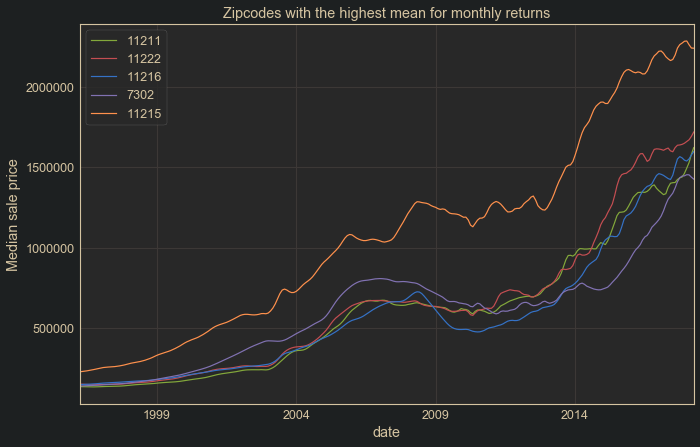

In [50]:
for i in range(5):
    name = ten_best_means.index[i]
    zip_code = groups.get_group(name)
    #display(zip_code.head())
    zip_code.set_index('date').value.plot(label=name)
plt.title("Zipcodes with the highest mean for monthly returns")
plt.ylabel("Median sale price")
plt.legend();

In [51]:
# As we can see, this has resulted in filtering to zip codes which were extraordinarily
# resilient to the crash, with some barely responding to the crisis.
# Another thing to note here is that these represent extremely expensive neighborhoods,
# which makes sense, since the wealthy would have been the least impacted by the economic crash
# This should make a handy benchmark to compare the monthly returns of zip codes which had
# incomplete data.
# Just out of curiosity, I'd like to run this process using the medians
indices = [ind for ind in medians.index if ind not in counts.keys()]
ten_best_medians = medians.loc[indices].sort_values(ascending=False).iloc[:10]
ten_best_medians

zipcode
2119     0.012063
94590    0.010718
2121     0.010642
94601    0.010595
86334    0.010589
7302     0.010361
94606    0.010297
90291    0.010271
11963    0.010095
2657     0.010090
dtype: float64

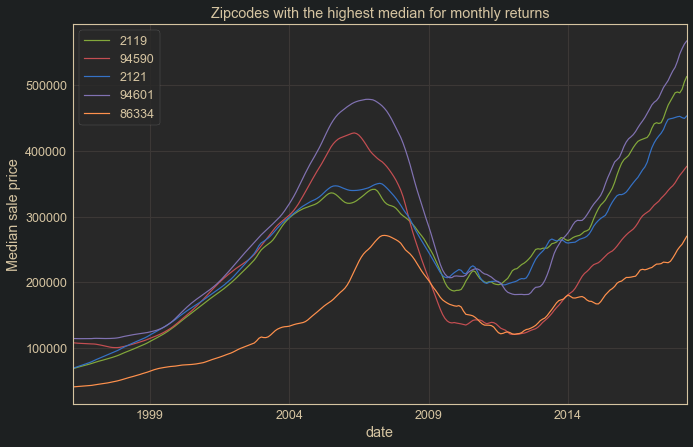

In [52]:
# We can see immediately that these values are higher, since the lower outliers have not 
# penalized the average as much. Let's look at a chart of the top 5
for i in range(5):
    name = ten_best_medians.index[i]
    zip_code = groups.get_group(name)
    #display(zip_code.head())
    zip_code.set_index('date').value.plot(label=name)
plt.title("Zipcodes with the highest median for monthly returns")
plt.ylabel("Median sale price")
plt.legend();

In [53]:
# Woof. We can see that these zip codes did not handle the crash nearly as well. Most of these
# lost over half of their value during the recession. These are much more lower- and middle-class 
# homes,and these would have been the houses that people were taking loans that turned out to be
# out of their ability to pay, which ultimately got foreclosed on. However, it should be noted
# that the rate of their recovery was very solid after around 2013, although this is probably
# just an artifact of slumping prices leaving them undervalued.

# We will continue from here using the means for analysis

City State     Metro CountyName   avgReturn
11211     New York    NY  New York      Kings  0.00947201
11222     New York    NY  New York      Kings    0.009263
11216     New York    NY  New York      Kings  0.00906309
7302   Jersey City    NJ  New York     Hudson  0.00887159
11215     New York    NY  New York      Kings  0.00869986

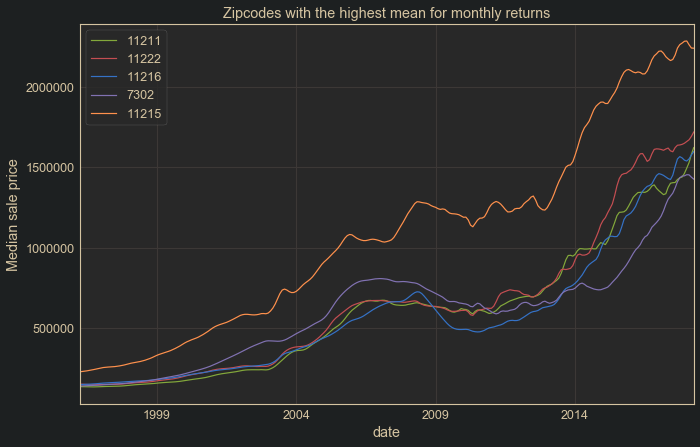

City State                           Metro  \
11975    Wainscott    NY                        New York   
11930   Amagansett    NY                        New York   
80449      Hartsel    CO                          Denver   
90291  Los Angeles    CA  Los Angeles-Long Beach-Anaheim   
20001   Washington    DC                      Washington   

                 CountyName   avgReturn  
11975               Suffolk  0.00869232  
11930               Suffolk  0.00855339  
80449                  Park  0.00829042  
90291           Los Angeles  0.00822843  
20001  District of Columbia  0.00816065

City State         Metro    CountyName   avgReturn
11932  Bridgehampton    NY      New York       Suffolk  0.00800523
11976     Water Mill    NY      New York       Suffolk  0.00792536
57110    Sioux Falls    SD   Sioux Falls     Minnehaha  0.00792513
19125   Philadelphia    PA  Philadelphia  Philadelphia   0.0078984
2120          Boston    MA        Boston       Suffolk  0.00789064

City State       Metro  CountyName   avgReturn
19951    Harbeson    DE   Salisbury      Sussex    0.007889
11221    New York    NY    New York       Kings  0.00780192
30317     Atlanta    GA     Atlanta      Fulton  0.00766231
78702      Austin    TX      Austin      Travis  0.00765756
29403  Charleston    SC  Charleston  Charleston   0.0076441

City State          Metro     CountyName   avgReturn
94306      Palo Alto    CA       San Jose    Santa Clara  0.00760991
94110  San Francisco    CA  San Francisco  San Francisco  0.00760793
28762       Old Fort    NC         Marion       McDowell  0.00760581
11963         Noyack    NY       New York        Suffolk  0.00760503
2119          Boston    MA         Boston        Suffolk  0.00760167

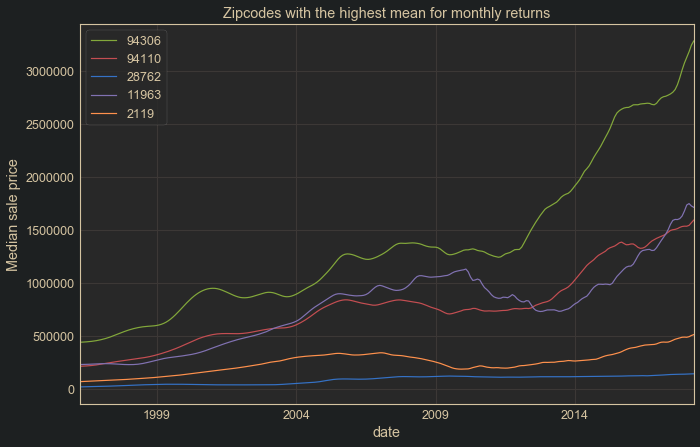

City State                           Metro  \
20002     Washington    DC                      Washington   
94303      Palo Alto    CA                        San Jose   
90038    Los Angeles    CA  Los Angeles-Long Beach-Anaheim   
94043  Mountain View    CA                        San Jose   
11937   East Hampton    NY                        New York   

                 CountyName   avgReturn  
20002  District of Columbia  0.00754581  
94303           Santa Clara  0.00753192  
90038           Los Angeles  0.00745056  
94043           Santa Clara   0.0074316  
11937               Suffolk  0.00742898

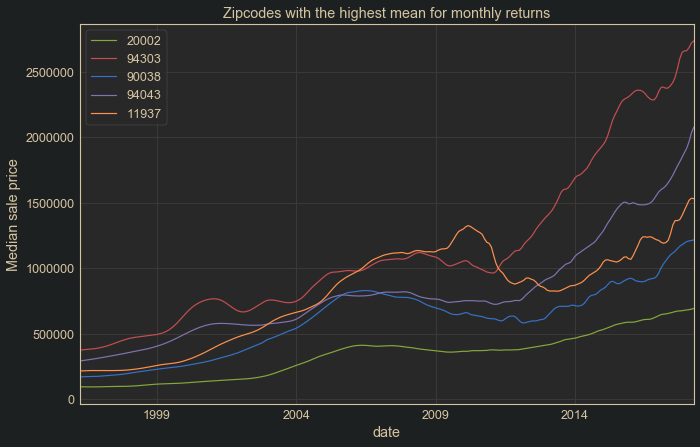

City State                           Metro  \
20010    Washington    DC                      Washington   
90026   Los Angeles    CA  Los Angeles-Long Beach-Anaheim   
90048   Los Angeles    CA  Los Angeles-Long Beach-Anaheim   
19147  Philadelphia    PA                    Philadelphia   
90028   Los Angeles    CA  Los Angeles-Long Beach-Anaheim   

                 CountyName   avgReturn  
20010  District of Columbia  0.00739382  
90026           Los Angeles  0.00739197  
90048           Los Angeles  0.00736925  
19147          Philadelphia  0.00733891  
90028           Los Angeles  0.00732217

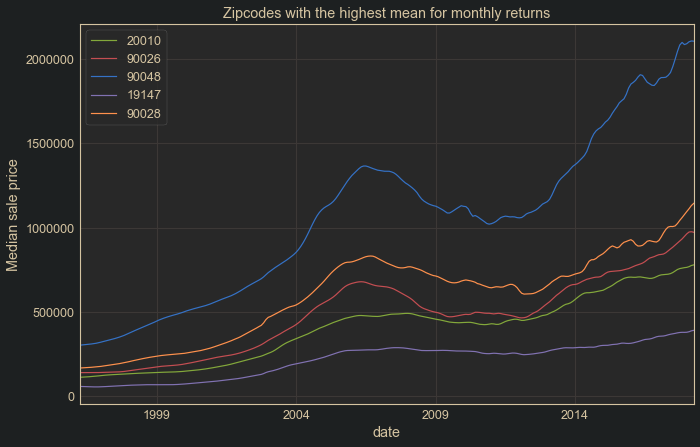

City State        Metro   CountyName   avgReturn
11218       New York    NY     New York        Kings  0.00731085
94040  Mountain View    CA     San Jose  Santa Clara  0.00730095
80205         Denver    CO       Denver       Denver  0.00729196
11233       New York    NY     New York        Kings  0.00728649
57005        Brandon    SD  Sioux Falls    Minnehaha  0.00726574

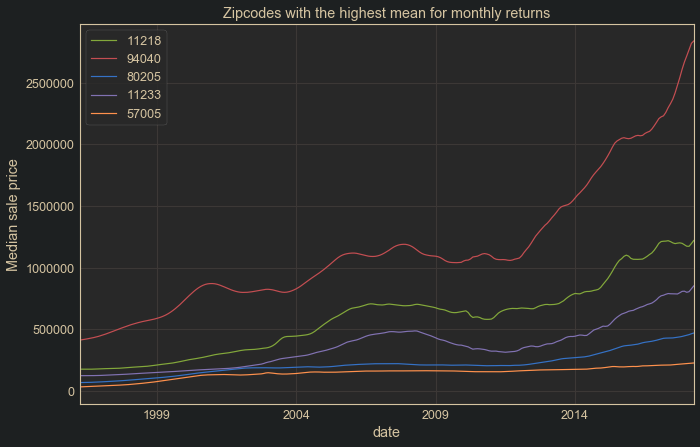

City State          Metro    CountyName   avgReturn
80456     Jefferson    CO         Denver          Park  0.00726346
94609       Oakland    CA  San Francisco       Alameda  0.00726232
94301     Palo Alto    CA       San Jose   Santa Clara   0.0072562
71241   Farmerville    LA         Monroe         Union  0.00725226
19123  Philadelphia    PA   Philadelphia  Philadelphia  0.00721051

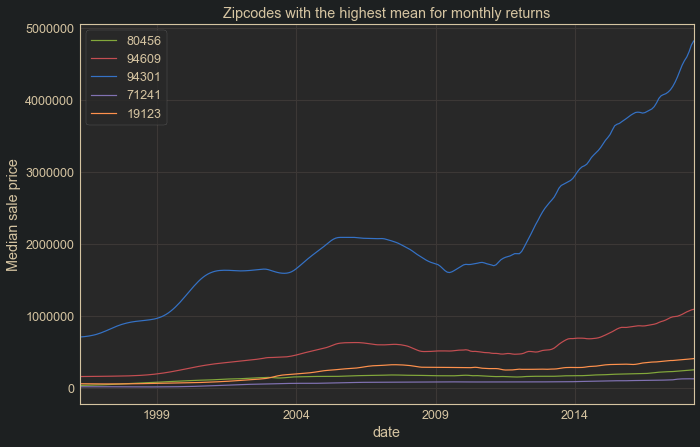

City State                           Metro   CountyName  \
11106       New York    NY                        New York     New York   
94041  Mountain View    CA                        San Jose  Santa Clara   
11968    Southampton    NY                        New York      Suffolk   
11102       New York    NY                        New York       Queens   
90019    Los Angeles    CA  Los Angeles-Long Beach-Anaheim  Los Angeles   

        avgReturn  
11106  0.00721003  
94041  0.00717392  
11968  0.00715202  
11102  0.00714574  
90019  0.00714227

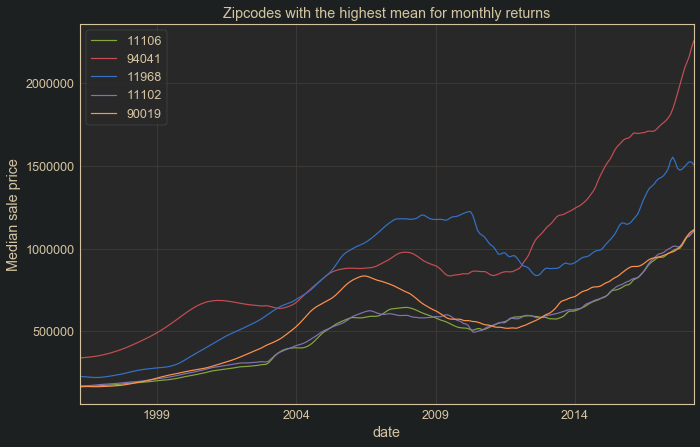

In [56]:
# What I will do now, to see if I can find any zip codes which were resilient, but also don't 
# cost a fortune to invest in, is iterate over the highest mean returns a few times, 5 at a time
# to see what I can find.

# Getting an ordered list of best performing zip codes
best_means = log_ret_means.loc[indices].sort_values(ascending=False)

# Creating a df to generate rows for view_dfs generated below
zips_df = df.set_index('zipcode')[['City', 
                                  'State', 
                                  'Metro', 
                                  'CountyName']].merge(pd.Series(best_means, 
                                                                 name='avgReturn'), 
                                                       left_index=True, 
                                                       right_on='zipcode')

n = 0
for i in range(10):
    j = 0
    view_df = pd.DataFrame()
    while j < 5:
        name = best_means.index[n]
        zip_code = groups.get_group(name)
        zip_code.set_index('date').value.plot(label=name)
        n += 1
        j += 1
        view_df = pd.concat([view_df, pd.DataFrame(zips_df.loc[name]).T], axis=0)
        
    display(view_df)
    plt.title("Zipcodes with the highest mean for monthly returns")
    plt.ylabel("Median sale price")
    plt.legend()
    plt.show()

Now that we have narrowed our view to zipcodes that have performed very well over the time frame, we notice that some of these zipcodes contain very expensive properties on average, up in the millions of dollars. Since buying and holding properties in hopes of capital appreciation comes with costs (property tax, insurance, maintenance, and lost risk-free-rate investment), a real estate investment company would need to consider renting the properties it is holding over the investment horizon. This leads us to some questions: if the goal is to rent properties in the short term, what are the differences in renting luxury houses (million dollar homes) vs utility houses? Are there renters for luxury homes? What is the difference in profitability of renting luxury homes vs utility homes?<br>
<br>
A [very informative article](https://www.financialsamurai.com/real-estate-investing-rule-rent-luxury-buy-utility/) written by Sam Dogen, founder of Financial Samurai, explains the scenario from the perspective of a real estate investor and consultant. Dogen explains a principle that he calls BURL (Buy Utility, Rent Luxury), explaining that luxury homes, especially in coastal cities, tend to not have near the yearly profitability through renting as utility homes, and often have no profitability at all, with the rent merely covering the expenses of ownership, and in some cases not even doing that. He also mentions that the "valuations are stretched in expensive coastal cities." <br>
<br>
Here is an informative graphic from the article, sourced from [Zillow](https://www.zillow.com/research/where-rent-covers-mortgage-15624/):
![Zillow Analysis Graphic](https://i2.wp.com/financialsamurai.com/wp-content/uploads/2017/06/where-it-pays-to-be-a-landlord.jpg?fit=1456,9999)<br>

We can see from the chart that big expensive coastal cities have a low chance of profitability for renting out properties. Dogen makes clear in the article that it is better to buy less expensive properties in non-luxury cities, especially those in the Midwest, which can be rented for a much higher ratio to their value, in order to generate income. This means that for our client, we should be looking for the zip codes with the strongest growth and best resilience that do not predominantly contain expensive luxury homes. Therefore, the search can be narrowed to zip codes with current average home prices less than $ 500k to avoid shopping for luxury homes.

City State         Metro    CountyName   avgReturn
80449       Hartsel    CO        Denver          Park  0.00829042
57110   Sioux Falls    SD   Sioux Falls     Minnehaha  0.00792513
19125  Philadelphia    PA  Philadelphia  Philadelphia   0.0078984
19951      Harbeson    DE     Salisbury        Sussex    0.007889
30317       Atlanta    GA       Atlanta        Fulton  0.00766231

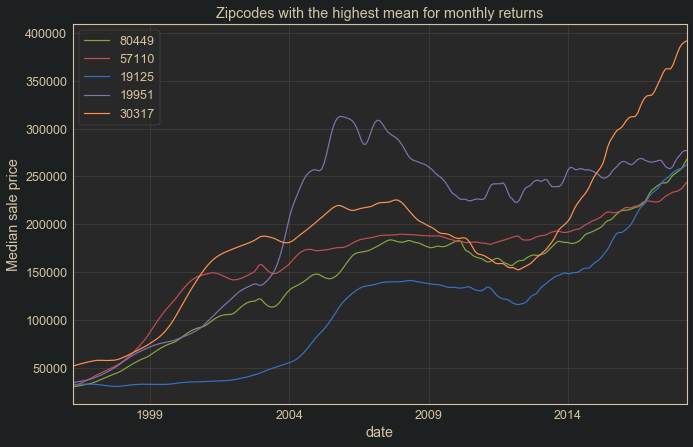

City State         Metro    CountyName   avgReturn
78702        Austin    TX        Austin        Travis  0.00765756
29403    Charleston    SC    Charleston    Charleston   0.0076441
28762      Old Fort    NC        Marion      McDowell  0.00760581
19147  Philadelphia    PA  Philadelphia  Philadelphia  0.00733891
80205        Denver    CO        Denver        Denver  0.00729196

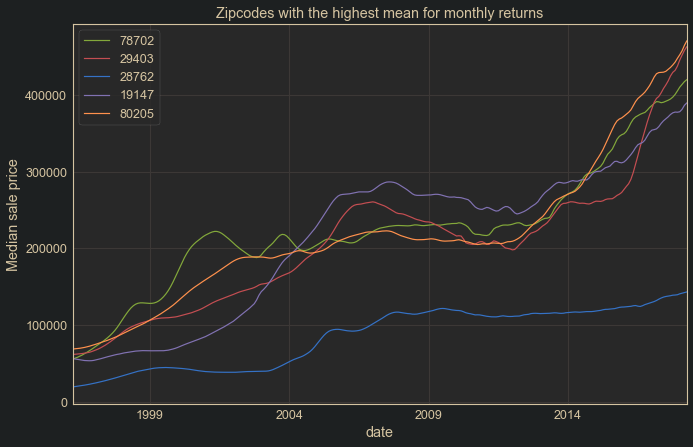

City State         Metro    CountyName   avgReturn
57005       Brandon    SD   Sioux Falls     Minnehaha  0.00726574
80456     Jefferson    CO        Denver          Park  0.00726346
71241   Farmerville    LA        Monroe         Union  0.00725226
19123  Philadelphia    PA  Philadelphia  Philadelphia  0.00721051
71234    Downsville    LA        Monroe         Union  0.00713303

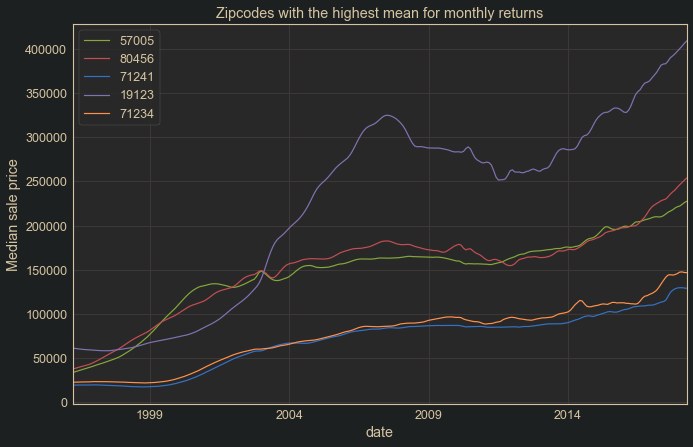

City State                Metro CountyName   avgReturn
86334       Paulden    AZ             Prescott    Yavapai  0.00712895
2121         Boston    MA               Boston    Suffolk  0.00710357
33947  Rotonda West    FL          Punta Gorda  Charlotte  0.00710352
55449        Blaine    MN  Minneapolis-St Paul      Anoka  0.00707305
68523       Lincoln    NE              Lincoln  Lancaster  0.00683372

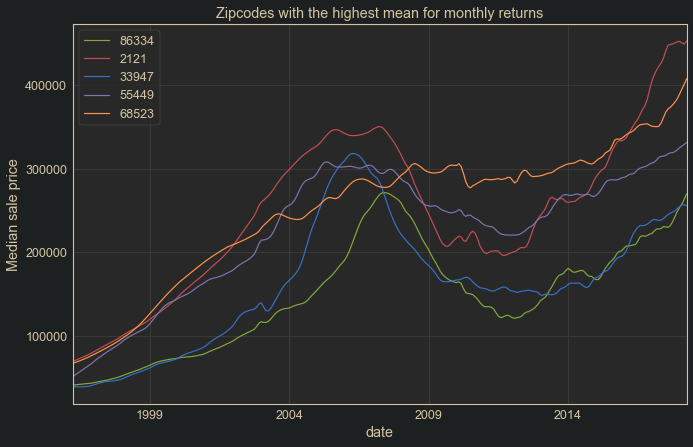

City State        Metro  CountyName   avgReturn
27583     Timberlake    NC       Durham      Person  0.00677721
57030      Garretson    SD  Sioux Falls   Minnehaha  0.00676346
37046  College Grove    TN    Nashville  Williamson  0.00674437
2128          Boston    MA       Boston     Suffolk  0.00671118
16611         Porter    PA   Huntingdon  Huntingdon  0.00663976

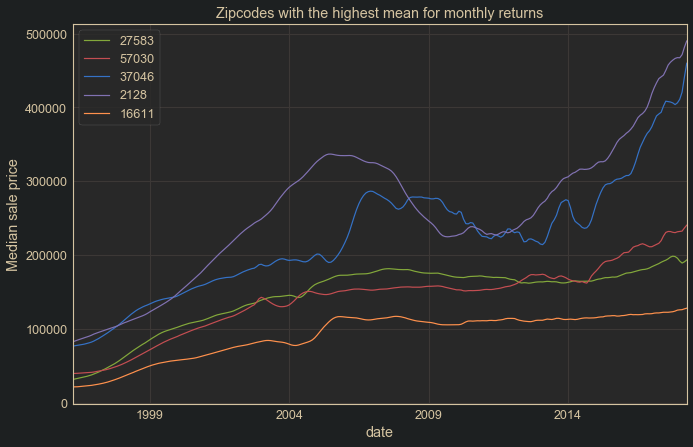

City State          Metro    CountyName   avgReturn
33701  Saint Petersburg    FL          Tampa      Pinellas  0.00661395
30547             Homer    GA            NaN         Banks  0.00660741
19130      Philadelphia    PA   Philadelphia  Philadelphia  0.00652333
15681        Loyalhanna    PA     Pittsburgh  Westmoreland  0.00652187
16844             Union    PA  State College        Centre  0.00650503

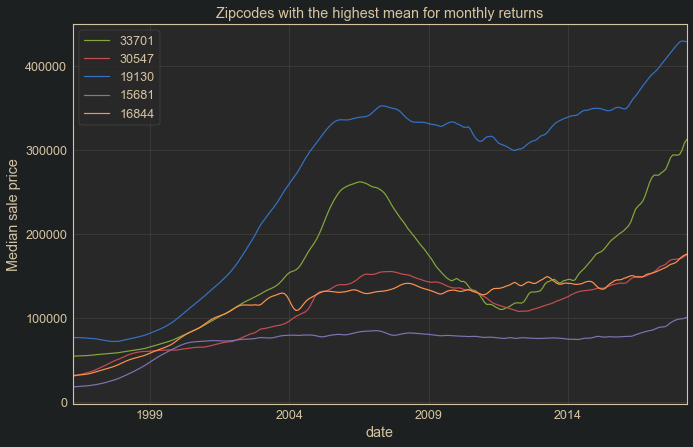

City State       Metro  CountyName   avgReturn
16669     Jackson    PA  Huntingdon  Huntingdon  0.00649649
78722      Austin    TX      Austin      Travis  0.00644289
97211    Portland    OR    Portland   Multnomah  0.00638069
15201  Pittsburgh    PA  Pittsburgh   Allegheny  0.00637644
30530    Commerce    GA   Jefferson     Jackson  0.00635241

City State          Metro      CountyName   avgReturn
16875      Gregg    PA  State College          Centre  0.00633948
21231  Baltimore    MD      Baltimore  Baltimore City   0.0063352
19966  Millsboro    DE      Salisbury          Sussex   0.0063349
15687    Donegal    PA     Pittsburgh    Westmoreland  0.00632457
49814   Champion    MI      Marquette       Marquette  0.00631257

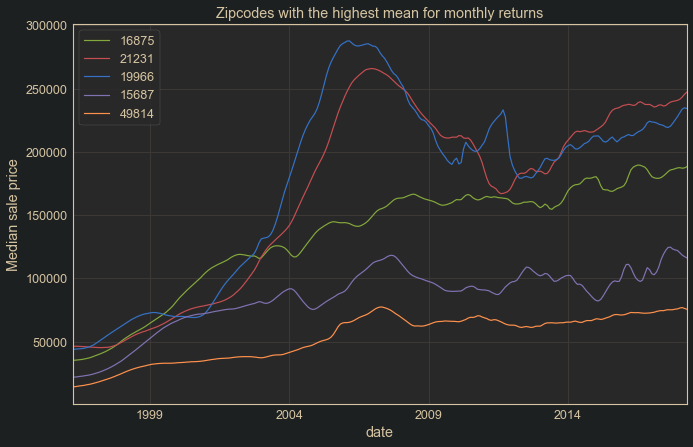

City State          Metro    CountyName   avgReturn
80207         Denver    CO         Denver        Denver  0.00630566
32680       Old Town    FL            NaN         Dixie  0.00629791
73103  Oklahoma City    OK  Oklahoma City      Oklahoma  0.00629502
80440       Fairplay    CO         Denver          Park  0.00627703
19145   Philadelphia    PA   Philadelphia  Philadelphia   0.0062124

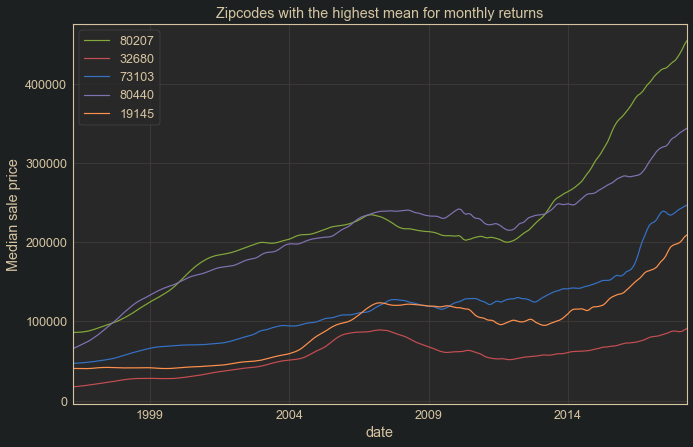

City State          Metro      CountyName   avgReturn
57003        Baltic    SD    Sioux Falls       Minnehaha   0.0062019
16870        Patton    PA  State College          Centre  0.00619539
17860      Shamokin    PA        Sunbury  Northumberland  0.00618594
19148  Philadelphia    PA   Philadelphia    Philadelphia  0.00618021
80204        Denver    CO         Denver          Denver  0.00617984

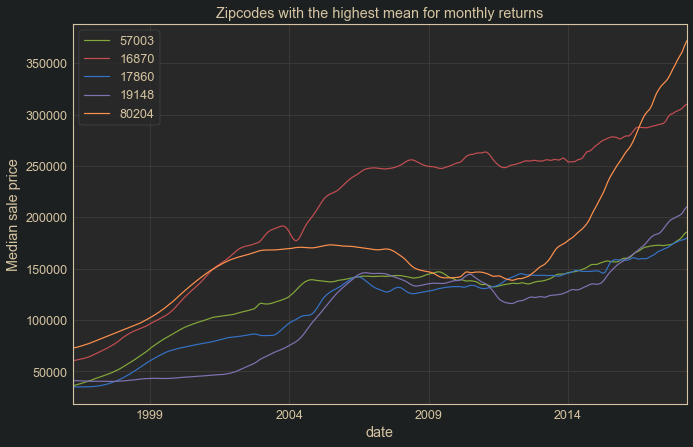

In [57]:
# Repeating the search process from above, but applying the price filter.

# Getting an ordered list of best performing zip codes
best_means = log_ret_means.loc[indices].sort_values(ascending=False)

# Creating a df to generate rows for view_dfs generated below
zips_df = df.set_index('zipcode')[['City', 
                                  'State', 
                                  'Metro', 
                                  'CountyName']].merge(pd.Series(best_means, 
                                                                 name='avgReturn'), 
                                                       left_index=True, 
                                                       right_on='zipcode')

n = 0
for i in range(10):
    j = 0
    view_df = pd.DataFrame()
    while j < 5:
        name = best_means.index[n]
        zip_code = groups.get_group(name)
        
        # Continue loop if most recent value is over 500k
        if zip_code.set_index('date').value.iloc[-1] > 500000:
            n += 1
            continue
        #display(zip_code.head())
        else:
            zip_code.set_index('date').value.plot(label=name)
            n += 1
            j += 1
            view_df = pd.concat([view_df, pd.DataFrame(zips_df.loc[name]).T], axis=0)
    display(view_df)
    plt.title("Zipcodes with the highest mean for monthly returns")
    plt.ylabel("Median sale price")
    plt.legend()
    plt.show()

Now we can see top performing zip codes with current prices below $500k. Some are showing strong resilience during the crash and stable growth. Others have found their way into the list by having explosive periods of growth, especially in the last 5 years, and more volatility during the crash. Since less volatile assets with stable growth are generally considered safer for investors, this should be favored. However, some zip codes which barely felt the crash also have boring growth in recent years, so a balance of strong recent growth and strength during the crash should be favored. I will now hand select a few zip codes and compile a list. I will not pick 2 zip codes in the same metro, to avoid position concentration risk. I will also avoid visibly more volatile zip codes, since these are more risky to investors.

In [64]:
# 23 zip codes meeting our criteria so far
good_zips = [80449, 19125, 57110, 19951, 30317, 78702, 29403, 28762, 2119, 19147, 
             80205, 80456, 71241, 71234, 86334, 68523, 27583, 16611, 30547, 15201, 
             49814, 73103, 17860,
            ]
best_means.loc[good_zips]

zipcode
80449    0.008290
19125    0.007898
57110    0.007925
19951    0.007889
30317    0.007662
78702    0.007658
29403    0.007644
28762    0.007606
2119     0.007602
19147    0.007339
80205    0.007292
80456    0.007263
71241    0.007252
71234    0.007133
86334    0.007129
68523    0.006834
27583    0.006777
16611    0.006640
30547    0.006607
15201    0.006376
49814    0.006313
73103    0.006295
17860    0.006186
dtype: float64

City State         Metro    CountyName   avgReturn
80449       Hartsel    CO        Denver          Park  0.00829042
19125  Philadelphia    PA  Philadelphia  Philadelphia   0.0078984
57110   Sioux Falls    SD   Sioux Falls     Minnehaha  0.00792513
19951      Harbeson    DE     Salisbury        Sussex    0.007889
30317       Atlanta    GA       Atlanta        Fulton  0.00766231

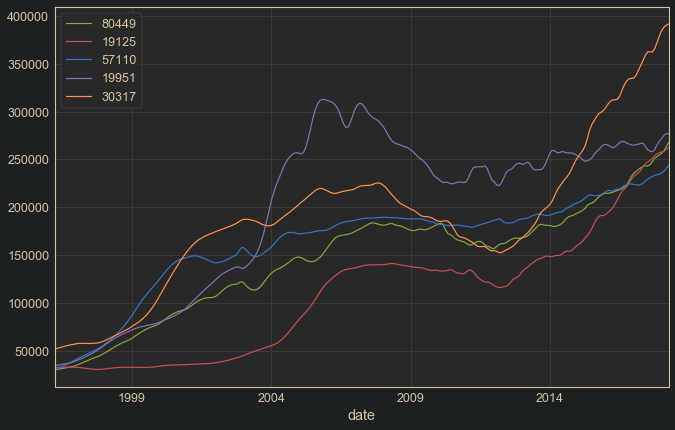

City State         Metro    CountyName   avgReturn
78702        Austin    TX        Austin        Travis  0.00765756
29403    Charleston    SC    Charleston    Charleston   0.0076441
28762      Old Fort    NC        Marion      McDowell  0.00760581
2119         Boston    MA        Boston       Suffolk  0.00760167
19147  Philadelphia    PA  Philadelphia  Philadelphia  0.00733891

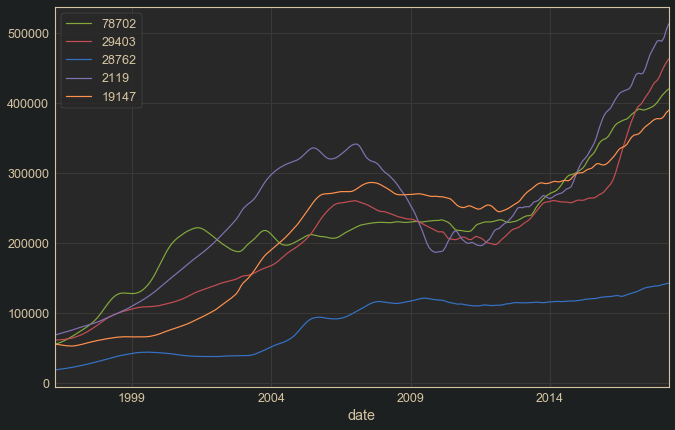

City State     Metro CountyName   avgReturn
80205       Denver    CO    Denver     Denver  0.00729196
80456    Jefferson    CO    Denver       Park  0.00726346
71241  Farmerville    LA    Monroe      Union  0.00725226
71234   Downsville    LA    Monroe      Union  0.00713303
86334      Paulden    AZ  Prescott    Yavapai  0.00712895

City State       Metro  CountyName   avgReturn
68523     Lincoln    NE     Lincoln   Lancaster  0.00683372
27583  Timberlake    NC      Durham      Person  0.00677721
16611      Porter    PA  Huntingdon  Huntingdon  0.00663976
30547       Homer    GA         NaN       Banks  0.00660741
15201  Pittsburgh    PA  Pittsburgh   Allegheny  0.00637644

City State          Metro      CountyName   avgReturn
49814       Champion    MI      Marquette       Marquette  0.00631257
73103  Oklahoma City    OK  Oklahoma City        Oklahoma  0.00629502
17860       Shamokin    PA        Sunbury  Northumberland  0.00618594

In [65]:
zips_df = df.set_index('zipcode').loc[good_zips][['City', 
                                                  'State', 
                                                  'Metro', 
                                                  'CountyName']].merge(pd.Series(best_means.loc[good_zips], 
                                                                                 name='avgReturn'), 
                                                                       left_index=True, 
                                                                       right_on='zipcode')

i = 1
view_df = pd.DataFrame()
for idx in good_zips:
    grp = groups.get_group(idx)
    view_df = pd.concat([view_df, pd.DataFrame(zips_df.loc[idx]).T], axis=0)
    grp.set_index('date').value.plot(label=idx)
    if i % 5 == 0 or idx == good_zips[-1]:
        display(view_df)
        view_df = pd.DataFrame()
        plt.legend()
        plt.show()
    i += 1

A few things to note now that we have narrowed our view down to 23 zip codes is that among these candidates, some had better growth before the crash, then have mostly leveled off since then, while others have shown very strong growth more recently. Since our client would be investing in the current market, it is likely that it would be better to select the zip codes which are currently showing momentum. Too much momentum could sometimes be a sign that the houses are becoming overpriced and may decline in the near future, however.<br>

Boston can be thrown out, since it is below the profitablility line on the above chart. Sioux Falls, SD looks like a gem, with a nice linear upward trend, and a location which is not considered luxury. Brandon is in the same area, with a similar growth curve.<br>

Harbeson can probably be ignored, because it has not had strong growth in the recent years. It is on this list mostly because of its resiliency to the crash and its rapid growth prior to it.<br>

Philadelphia looks good, being resilient and having strong recent growth. The Atlanta zipcode has shown very strong growth in recent years. Sometimes fast growth means an upcoming pull back, but we'll keep this zip code in mind, as Atlanta is quite high up on the above Zillow list. A Google search reveals that this zip code is right outside of downtown, making it quite urban.<br>

Hartsel, CO looks goood, because it is in the Denver metro area, but a wikipedia and google search shows that it is a 2hr drive, with a population of 667, up in the mountains, so it may be somewhat of a luxury area. Nevertheless, the property is appreciating nicely, with the highest average monthly return on this list, so it might be worth consideration. A google search led me to [Xome.com](https://www.xome.com/homes-for-sale/CO/Hartsel), which says that in Hartsel, "approximately 31.24% of Hartsel homes are owned, compared to 0.48% rented, while 68.28% are vacant." Therefore, this is not a good prospect for real estate investors. Jefferson, CO is similarly located over an hour outside of Denver in a rural area with a small population.<br>

Denver, on the other hand, looks stable and has strong recent growth, and is above the rent profitablility line on the chart. It may make a good urban investment, as Denver has gotten very popular over the course of the past decade.<br>

Austin, although somewhat volatile, shows both resilience and strong recent growth. Charleston is quite volatile and the recent growth looks possibly unsustainable. <br>

Old Fort is intriguing. It has low prices, and was quite resilient to the crash. I am actually familiar with the town, as I used to drive past it on my way in and out of Asheville, NC, which is a rapidly growing area with high real estate prices. Old Fort is only 37 minutes away, and much cheaper, so it stands to reason that people might invest in Old Fort and commute to Asheville.<br>

Farmerville, LA is probably too small to consider, with not much more than a Wal-Mart, in a rural area of Louisiana. Downsville LA is nearly nonexistent, with a population of 137. Paulden, AZ, is much more volatile than the other options.<br>

Lincoln, NE is comparably volatile, but has great resilience and recent growth. Timberlake is relatively flat, but may have good value. Pittsburg, PA is looking very strong recently, and flat through the crisis, although the prices are quite low. <br>

Champion, MI is showing very stable upward growth and low volatility. Oklahoma city is showing very strong recent growth on top of stable upward growth through the crash. Shamokin, PA is also looking pretty good.

#### A note on investment diversity and risk exposure:
In finance, portfolio managers diversify investments in order to limit the amount of certain types of risk the portfolio is exposed to. This is often thought of in terms of sector (technology, financials, etc), but risk can be regional as well. This means that for a real estate investor, putting all of your eggs in one geographical basket is more risky than spreading them around, because something that affects one area may not affect another, and also something that affects metropolitan areas may affect more rural areas differently. In the context of this client, it stands to reason that they should invest in various areas, with some in urban areas, and some in more (but not completely) rural areas.

### Looking at zipcodes with missing data

In [74]:
# Let's take a fresh look at the dictionary of zipcodes that were missing data, and how many
# NaNs they contained
for k, v in counts.items():
    print('{}: {}'.format(k, v))

2116: 219
2301: 87
2302: 87
3215: 171
3240: 195
3256: 87
3838: 111
4008: 117
4009: 219
4037: 87
4093: 159
4357: 117
4429: 111
4530: 117
4562: 117
4963: 87
10011: 105
10014: 93
10021: 93
10456: 213
10459: 87
10550: 171
11101: 189
11205: 93
11217: 93
11231: 93
11238: 93
11749: 213
11944: 87
12138: 171
12428: 213
12458: 213
12775: 87
12783: 87
12790: 87
13607: 183
13656: 201
13797: 213
14025: 87
14030: 87
14032: 87
14033: 87
14080: 87
14201: 177
14222: 87
14716: 183
15067: 183
15333: 171
15442: 177
15552: 117
15931: 201
15943: 213
15958: 201
16041: 189
16102: 87
16112: 87
16116: 87
16120: 87
16142: 87
16143: 87
16156: 87
16157: 87
16613: 201
16625: 219
16637: 177
16912: 171
17236: 93
17252: 93
17744: 201
17752: 177
17771: 201
17965: 207
18252: 207
18326: 87
18332: 87
18344: 87
18350: 87
18372: 87
18435: 117
18444: 117
19901: 159
19904: 159
19934: 159
19938: 153
19939: 87
19943: 159
19945: 87
19946: 153
19952: 159
19953: 153
19954: 219
19962: 159
19963: 171
19964: 153
19977: 105
20871: 87


In [75]:
# I think the best way to deal with the variety of time windows missing from these zipcodes
# is to split them into lists which correspond to their amount of missing data, stored in 
# a dictionary, then iterate through the various missing data lengths, dropping any zip codes
# which have more missing data, then running a full comparison, and seeing if any of the newly
# added zip codes at any missing data length appear in the list of top 50 performing zip codes
# that result.
# First, I'm going to regenerate the original dictionary with ascending values
res = dict(sorted(counts.items(), key = itemgetter(1), reverse = False)) 
res

{23047: 15,
 23015: 21,
 23192: 21,
 2301: 87,
 2302: 87,
 3256: 87,
 4037: 87,
 4963: 87,
 10459: 87,
 11944: 87,
 12775: 87,
 12783: 87,
 12790: 87,
 14025: 87,
 14030: 87,
 14032: 87,
 14033: 87,
 14080: 87,
 14222: 87,
 16102: 87,
 16112: 87,
 16116: 87,
 16120: 87,
 16142: 87,
 16143: 87,
 16156: 87,
 16157: 87,
 18326: 87,
 18332: 87,
 18344: 87,
 18350: 87,
 18372: 87,
 19939: 87,
 19945: 87,
 20871: 87,
 21738: 87,
 21875: 87,
 24013: 87,
 24016: 87,
 27939: 87,
 27948: 87,
 27949: 87,
 27954: 87,
 27958: 87,
 28574: 87,
 28634: 87,
 28660: 87,
 30103: 87,
 30120: 87,
 30121: 87,
 30139: 87,
 30145: 87,
 30171: 87,
 30178: 87,
 30184: 87,
 31523: 87,
 31757: 87,
 32033: 87,
 32343: 87,
 32465: 87,
 33859: 87,
 34288: 87,
 34773: 87,
 37882: 87,
 42776: 87,
 45305: 87,
 45314: 87,
 45335: 87,
 45370: 87,
 45385: 87,
 45387: 87,
 45430: 87,
 48650: 87,
 48708: 87,
 49620: 87,
 50109: 87,
 50323: 87,
 55129: 87,
 55360: 87,
 56096: 87,
 57018: 87,
 57020: 87,
 57033: 87,
 57035: 8

In [76]:
last_length = 0
zip_groups = {}
lst = []
for k, v in res.items():
    if v != last_length:
        if len(lst) > 0:
            zip_groups[last_length] = lst
        lst = [k]
        last_length = v
    else:
        lst.append(k)

In [77]:
zip_groups

{15: [23047],
 21: [23015, 23192],
 87: [2301,
  2302,
  3256,
  4037,
  4963,
  10459,
  11944,
  12775,
  12783,
  12790,
  14025,
  14030,
  14032,
  14033,
  14080,
  14222,
  16102,
  16112,
  16116,
  16120,
  16142,
  16143,
  16156,
  16157,
  18326,
  18332,
  18344,
  18350,
  18372,
  19939,
  19945,
  20871,
  21738,
  21875,
  24013,
  24016,
  27939,
  27948,
  27949,
  27954,
  27958,
  28574,
  28634,
  28660,
  30103,
  30120,
  30121,
  30139,
  30145,
  30171,
  30178,
  30184,
  31523,
  31757,
  32033,
  32343,
  32465,
  33859,
  34288,
  34773,
  37882,
  42776,
  45305,
  45314,
  45335,
  45370,
  45385,
  45387,
  45430,
  48650,
  48708,
  49620,
  50109,
  50323,
  55129,
  55360,
  56096,
  57018,
  57020,
  57033,
  57035,
  57078,
  57104,
  57105,
  57106,
  57107,
  61011,
  63101,
  68832,
  72764,
  73150,
  78616,
  79415,
  80642,
  83263,
  86315,
  86413,
  89448,
  89449,
  93529,
  93546,
  93664,
  95228,
  95249,
  95453,
  96020,
  96708,
  9

In [78]:
# checking how using the dictionary keys with iloc would work
log_rets.iloc[15:][23047].head()

1997-07         NaN
1997-08    0.042354
1997-09    0.041769
1997-10    0.040094
1997-11    0.038549
Name: 23047, dtype: float64

In [79]:
# we can see that we'll need to add 1 to each key to correctly limit the time window
log_rets.iloc[15+1:][23047].head()

1997-08    0.042354
1997-09    0.041769
1997-10    0.040094
1997-11    0.038549
1997-12    0.041158
Name: 23047, dtype: float64

In [82]:
log_rets.iloc[15+1:].mean()

zipcode
60657    0.004314
75070    0.002087
77494    0.002107
60614    0.003902
79936    0.001790
           ...   
1338     0.003215
3293     0.003730
40404    0.003039
81225    0.004470
89155    0.002818
Length: 14723, dtype: float64

zipcode
68526    0.00695
dtype: float64

zipcode
58801    0.008190
96771    0.005774
58563    0.005080
dtype: float64

zipcode
58318    0.00611
dtype: float64

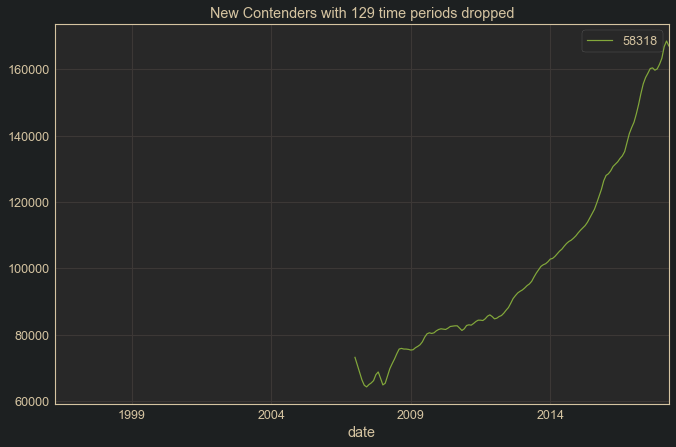

zipcode
85035    0.012214
dtype: float64

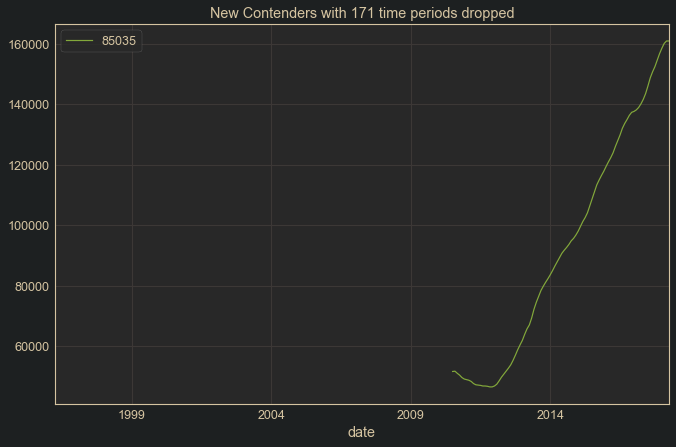

zipcode
33974    0.012062
33976    0.012003
dtype: float64

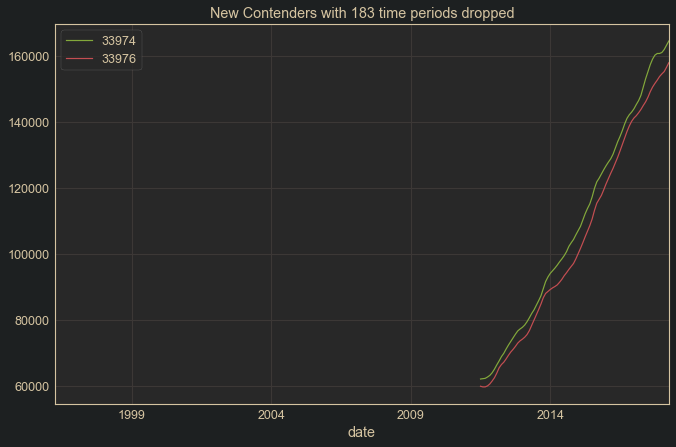

zipcode
80216    0.016964
dtype: float64

zipcode
30032    0.020352
89030    0.015623
94621    0.015365
dtype: float64

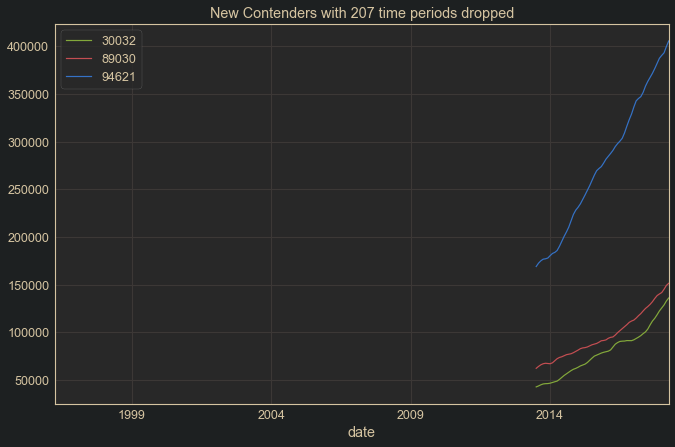

zipcode
27980    0.021365
dtype: float64

In [91]:
# The dictionary is ready, now to make comparisons on each time window
contenders = {}

# Find zip codes which are too expensive to invest in 
too_expensive = [group[0] for group in groups if group[1].set_index('date').value.iloc[-1] > 500000]

for k, v in zip_groups.items():
    to_drop = []
    
    # Create list of zip codes to drop which have missing data in the current time window
    for key, val, in zip_groups.items():
        if key > k:
            to_drop.append(val)
    to_drop = [item for sublist in to_drop for item in sublist] + too_expensive
    
    lrmeans = log_rets.iloc[k+1:].mean()
    indices = [ind for ind in lrmeans.index if ind not in to_drop]
    fifty_best = lrmeans.loc[indices].sort_values(ascending=False).iloc[:50]
    # Find any new zip codes appearing in top 50
    new_contenders = [x for x in fifty_best.index if x in v]
    new_contenders = fifty_best.loc[new_contenders]
    # create dictionary for current time window and store info
    contenders[k] = {}
    contenders[k]['contenders'] = new_contenders
    contenders[k]['fifty_best'] = fifty_best
    
    # display contenders of time window and plot them
    if len(new_contenders) > 0:
        display(new_contenders)
        for cont in new_contenders.index:
            grp = groups.get_group(cont)
            grp.set_index('date').value.plot(label=cont)
        plt.title('New Contenders with {} time periods dropped'.format(k))
        plt.legend()
    plt.show()

Average mean return of top fifty zip codes for time period: 0.006399695371876684


City State    Metro CountyName  avgReturn
zipcode                                              
68526    Lincoln    NE  Lincoln  Lancaster    0.00695

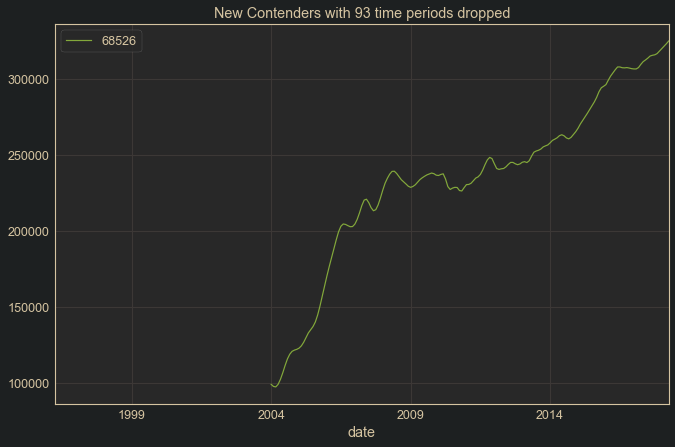

Average mean return of top fifty zip codes for time period: 0.0062105307490222215


City State      Metro CountyName  avgReturn
zipcode                                                      
58801        Williston    ND  Williston   Williams   0.008190
96771    Mountain View    HI       Hilo     Hawaii   0.005774
58563        New Salem    ND   Bismarck     Morton   0.005080

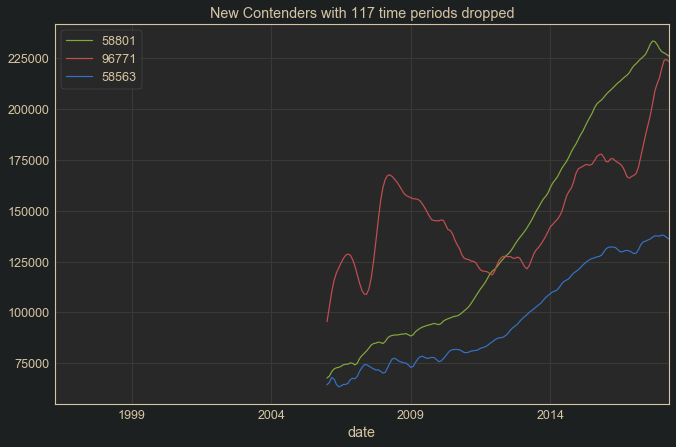

Average mean return of top fifty zip codes for time period: 0.006182764301550795


City State Metro CountyName  avgReturn
zipcode                                             
58318    Bottineau    ND   NaN  Bottineau    0.00611

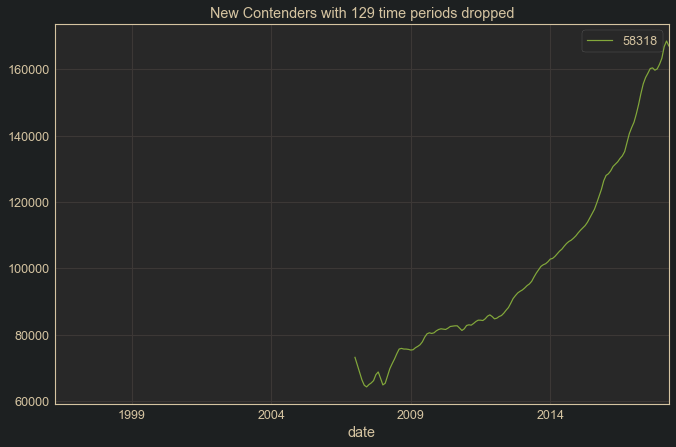

Average mean return of top fifty zip codes for time period: 0.010026749311486626


City State    Metro CountyName  avgReturn
zipcode                                              
85035    Phoenix    AZ  Phoenix   Maricopa   0.012214

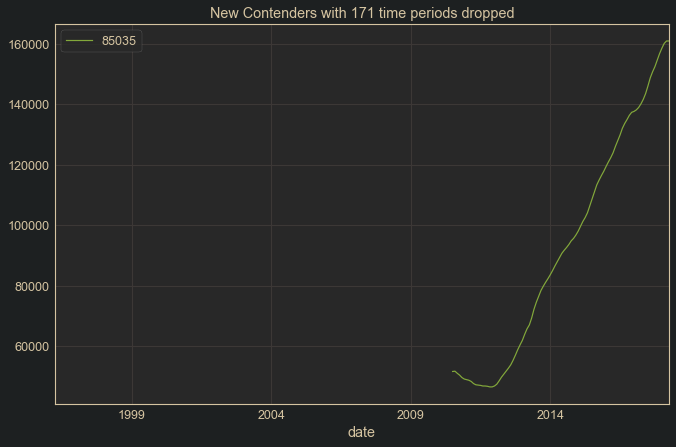

Average mean return of top fifty zip codes for time period: 0.012379337969543092


City State       Metro CountyName  avgReturn
zipcode                                                      
33974    Lehigh Acres    FL  Fort Myers        Lee   0.012062
33976    Lehigh Acres    FL  Fort Myers        Lee   0.012003

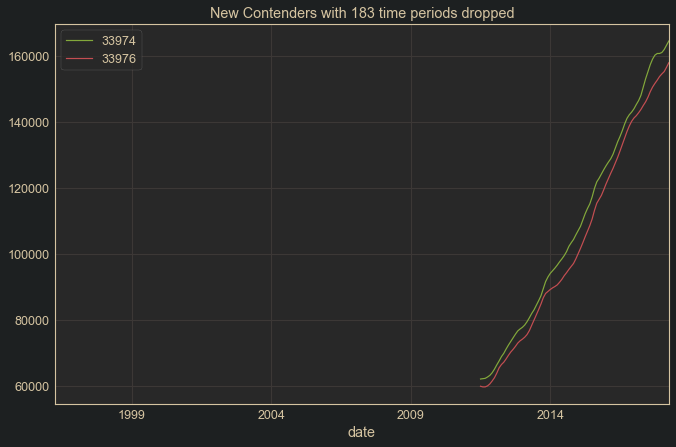

Average mean return of top fifty zip codes for time period: 0.01469338083596043


City State   Metro CountyName  avgReturn
zipcode                                            
80216    Denver    CO  Denver     Denver   0.016964

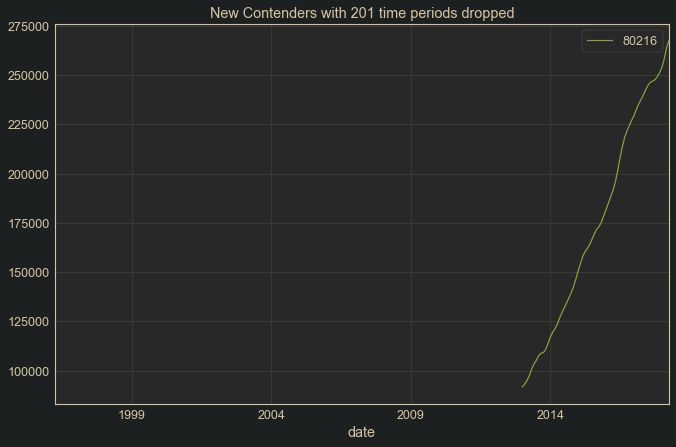

Average mean return of top fifty zip codes for time period: 0.014621808303300055


City State          Metro CountyName  avgReturn
zipcode                                                            
30032     Candler-Mcafee    GA        Atlanta     Dekalb   0.020352
89030    North Las Vegas    NV      Las Vegas      Clark   0.015623
94621            Oakland    CA  San Francisco    Alameda   0.015365

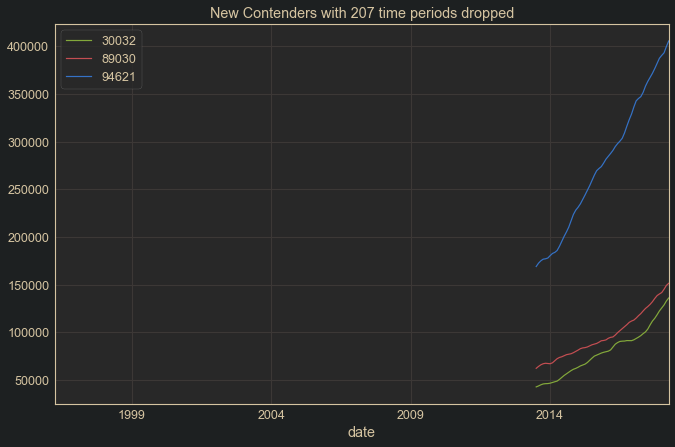

Average mean return of top fifty zip codes for time period: 0.015050289615549406


City State           Metro  CountyName  avgReturn
zipcode                                                       
27980    Hertford    NC  Elizabeth City  Perquimans   0.021365

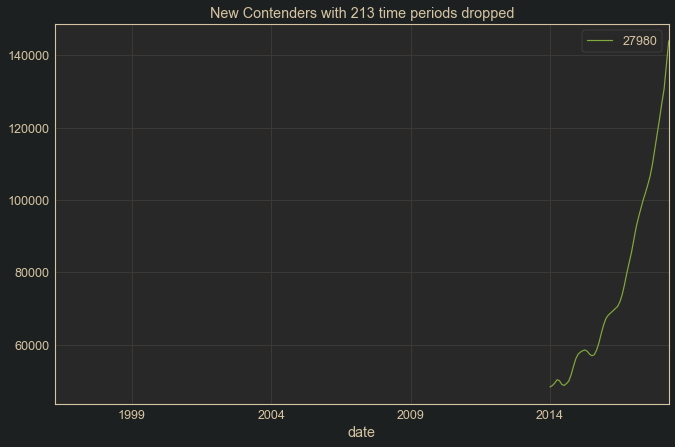

In [92]:
# We can see some promising contenders, and some to be ignored. I will ignore the 105 period
# drop, because we aren't in the market for $10 million houses
# We will also need to view these contenders in their relations to the other best zip codes
# in the time frames, so I will print the average mean return of the top fifty to see how
# the new contenders compare to the mean value
for k, v in contenders.items():
    if k == 105:
        continue
    if len(v['contenders']) > 0:
        idx = v['contenders'].index
        print('Average mean return of top fifty zip codes for time period: {}'.format(v['fifty_best'].mean()))
        zips_df = df.set_index('zipcode').loc[idx][['City', 
                                                  'State', 
                                                  'Metro', 
                                                  'CountyName']].merge(pd.Series(v['contenders'], 
                                                                                 name='avgReturn'), 
                                                                       left_index=True, 
                                                                       right_on='zipcode')
        display(zips_df)
        for cont in idx:
            grp = groups.get_group(cont)
            grp.set_index('date').value.plot(label=cont)
        plt.title('New Contenders with {} time periods dropped'.format(k))
        plt.legend()
        plt.show()
        
        #idx = v['fifty_best'].index
        #zips_df = df.set_index('zipcode').loc[idx][['City', 
        #                                          'State', 
        #                                          'Metro', 
        #                                          'CountyName']].merge(pd.Series(v['fifty_best'], 
        #                                                                         name='avgReturn'), 
        #                                                               left_index=True, 
        #                                                               right_on='zipcode')        
        #display(zips_df)
        print('===============================================================================')

#### Notes:
With 93 time periods dropped we see a contender from Lincoln, NE, which was a town that was already in our list of consideration.<br>
<br>
In the second time window we see a volatile zipcode in Hawaii which underperformed the average of the top fifty of this window, but we also see a promising zip code in Williston, North Dakota, which is certainly meeting our criteria for good investment, with rapid recent growth, resilience during the crash, and Midwestern location. New Salem is also a possibility, though it has a much lower mean return, and is in the same state.<br>
<br>
In the third time window, we see another promising North Dakota zip code, with strong recent growth. This is a much smaller town than the other ND zip code, however, with only a tenth of the population of Williston, so it may not be as good of a candidate for investment.<br>
<br>
In the fourth time window, we see a zip code in Phoenix, AZ, which is promising indeed. The growth rate is high, the Zillow chart shows that rentals are profitable, and it is a populous area with businesses, home to 1.66 million people.<br>
<br>
In the next time window we see two zipcodes from the same town in Florida called Lehigh Acres, which has shown excellent growth. At this point, no commentary on resiliency to the crash can be made, as it is outside the time window.<br>
<br>
The next window has a zipcode from Denver with reasonable prices and a good growth rate. Denver appears pretty low on our chart from earlier, nearby Austin, so it may not be a good choice, and we already had a Denver zip code on our list from earlier.
<br>
The next window shows three zip codes with reasonable prices outperforming the mean of the top 50 zip codes over this time period. The San Francisco one can probably be ignored, but the other two are promising. The one near Atlanta, Candler-McCafee has tremendous growth. The other is in Las Vegas, which appeared high on the Zillow Chart, and could be a good prospect.<br>
<br>
The final window shows a town called Hertford, NC, showing explosive growth since 2014, far exceeding the mean of performance of the top 50 zip codes over this time period. This is a small town on the Pariquimans River in eastern NC.

#### Notes so far:
This investigation has given us plently to choose from. In order to narrow down our candidates, I have found a useful metric and related data in [this Zillow Research article](https://www.zillow.com/research/where-rent-covers-mortgage-15624/) called Price to Rent Ratio. This ratio and parts of this article were also referenced in Sam Dogen's Investment Samurai article mentioned earlier. The article talks about the importance of an investor being sure that the amount that they can charge to rent a property is high enough to cover the costs of owning and maintaining the property. Both articles agree that this is most of an issue in larger metros on the West Coast and Northeast US. In some areas, the amount one can charge for rent will not cover the costs of ownership, so an investor needs to make sure that they are not buying in an area where this is a typical problem. But since breaking even with rent isn't as nice as profiting from rent, the ratio can help a keen investor get the most bang for their buck.<br>
<br>
The nationwide average (at the time of the article) of the Price-to-Rent Ratio was 11.4, meaning that it would take 11.4 years of rent to cover the cost of the house. In Sam Dogen's article, he recommended to invest in houses that trade at or below 9.6. Using this information, we should be able to narrow our choices down. It is likely that the more rural town on our list of contenders will not appear in this dataset, but we were hoping to diversify between rural and urban areas, so this should help us pinpoint which cities are most profitable. This is important since an investor with widely spread assets geographically will need to hire property management companies to attend to the maintenance and related issues of landlordship for their properties, which will take a cut. According to [this Zillow article](https://www.zillow.com/rental-manager/resources/hiring-a-property-manager/), a property management company will usually take a cut between 7% and 10% of monthly rent.

In [93]:
# Importing the data
p2r = pd.read_csv('data/price_to_rent.csv')
p2r.head()

Region Name Region Name (group)  National Average    P2R      Zhvi
0        Yuma, AZ               Other             11.44  12.18  $134,200
1   Yuba City, CA               Other             11.44  14.90  $249,400
2  Youngstown, OH               Other             11.44   8.86   $85,400
3        York, PA               Other             11.44  10.55  $163,600
4      Yakima, WA               Other             11.44  13.51  $181,700

In [197]:
#di.export(p2r.iloc[:5], 'images/p2r_head.png', max_cols = 15)

In [94]:
# Let's get a dataframe going of our candidates:
selections = [57110, 28762, 19125, 30317, 78702, 80205, 68526, 15201, 73103, 17860, 58801, 
              33974, 30032, 89030, 27980]
selections = df.set_index('zipcode').loc[selections]
selections

City State           Metro      CountyName  1996-04  \
zipcode                                                                   
57110        Sioux Falls    SD     Sioux Falls       Minnehaha  30100.0   
28762           Old Fort    NC          Marion        McDowell  19200.0   
19125       Philadelphia    PA    Philadelphia    Philadelphia  32600.0   
30317            Atlanta    GA         Atlanta          Fulton  51800.0   
78702             Austin    TX          Austin          Travis  55600.0   
80205             Denver    CO          Denver          Denver  68600.0   
68526            Lincoln    NE         Lincoln       Lancaster      NaN   
15201         Pittsburgh    PA      Pittsburgh       Allegheny  34400.0   
73103      Oklahoma City    OK   Oklahoma City        Oklahoma  46800.0   
17860           Shamokin    PA         Sunbury  Northumberland  35100.0   
58801          Williston    ND       Williston        Williams      NaN   
33974       Lehigh Acres    FL      Fort Myers             Lee      NaN   
30032     Candler-Mcafee    GA         Atlanta          Dekalb      NaN   
89030    North Las Vegas    NV       Las Vegas           Clark      NaN   
27980           Hertford    NC  Elizabeth City      Perquimans      NaN   

         1996-05  1996-06  1996-07  1996-08  1996-09  ...  2017-07  2017-08  \
zipcode                                               ...                     
57110    31200.0  32300.0  33400.0  34600.0  35800.0  ...   229500   230900   
28762    19700.0  20100.0  20600.0  21000.0  21500.0  ...   137100   137600   
19125    32700.0  32800.0  32800.0  32900.0  32900.0  ...   247500   249000   
30317    52500.0  53200.0  53900.0  54500.0  55200.0  ...   362500   362500   
78702    56700.0  57900.0  59300.0  60800.0  62500.0  ...   391700   393000   
80205    68900.0  69200.0  69600.0  70100.0  70700.0  ...   430700   433300   
68526        NaN      NaN      NaN      NaN      NaN  ...   313600   315000   
15201    34600.0  34700.0  34700.0  34800.0  34800.0  ...   162300   164400   
73103    47000.0  47300.0  47500.0  47700.0  47900.0  ...   237900   235200   
17860    35000.0  35000.0  35000.0  35000.0  35000.0  ...   170000   170900   
58801        NaN      NaN      NaN      NaN      NaN  ...   229200   231800   
33974        NaN      NaN      NaN      NaN      NaN  ...   155400   157500   
30032        NaN      NaN      NaN      NaN      NaN  ...   103300   107700   
89030        NaN      NaN      NaN      NaN      NaN  ...   126900   129200   
27980        NaN      NaN      NaN      NaN      NaN  ...   104200   106600   

         2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
zipcode                                                                  
57110     232200   233500   234000   234700   236000   237700   240800   
28762     138100   138800   139000   139400   140600   141400   142100   
19125     251600   253900   255700   257100   258000   258500   260500   
30317     362300   366000   372400   379200   384900   388400   390400   
78702     394600   397100   400600   405200   410100   413800   417300   
80205     435800   439000   442700   447700   452300   457500   464500   
68526     315500   315800   316600   318200   319700   321300   323100   
15201     166100   167600   169000   170400   171400   173900   179700   
73103     233900   235200   237300   239800   241800   243300   245100   
17860     172400   174100   175200   176300   177400   177900   178600   
58801     233400   233100   231600   229500   228100   227500   226800   
33974     159200   160400   160900   160900   161200   162100   163400   
30032     111700   114600   118300   122300   125400   128600   132800   
89030     132000   135400   138400   140100   141600   145100   149100   
27980     109900   114000   118100   122200   126600   130600   137300   

         2018-04  
zipcode           
57110     243900  
28762     143000  
19125     262300  
30317     391600  
78702     419800  
80205   

In [95]:
# Creating a new column in a similar format to the p2r data
selections['cityState'] = selections.Metro + ', ' + selections.State
selections

City State           Metro      CountyName  1996-04  \
zipcode                                                                   
57110        Sioux Falls    SD     Sioux Falls       Minnehaha  30100.0   
28762           Old Fort    NC          Marion        McDowell  19200.0   
19125       Philadelphia    PA    Philadelphia    Philadelphia  32600.0   
30317            Atlanta    GA         Atlanta          Fulton  51800.0   
78702             Austin    TX          Austin          Travis  55600.0   
80205             Denver    CO          Denver          Denver  68600.0   
68526            Lincoln    NE         Lincoln       Lancaster      NaN   
15201         Pittsburgh    PA      Pittsburgh       Allegheny  34400.0   
73103      Oklahoma City    OK   Oklahoma City        Oklahoma  46800.0   
17860           Shamokin    PA         Sunbury  Northumberland  35100.0   
58801          Williston    ND       Williston        Williams      NaN   
33974       Lehigh Acres    FL      Fort Myers             Lee      NaN   
30032     Candler-Mcafee    GA         Atlanta          Dekalb      NaN   
89030    North Las Vegas    NV       Las Vegas           Clark      NaN   
27980           Hertford    NC  Elizabeth City      Perquimans      NaN   

         1996-05  1996-06  1996-07  1996-08  1996-09  ...  2017-08  2017-09  \
zipcode                                               ...                     
57110    31200.0  32300.0  33400.0  34600.0  35800.0  ...   230900   232200   
28762    19700.0  20100.0  20600.0  21000.0  21500.0  ...   137600   138100   
19125    32700.0  32800.0  32800.0  32900.0  32900.0  ...   249000   251600   
30317    52500.0  53200.0  53900.0  54500.0  55200.0  ...   362500   362300   
78702    56700.0  57900.0  59300.0  60800.0  62500.0  ...   393000   394600   
80205    68900.0  69200.0  69600.0  70100.0  70700.0  ...   433300   435800   
68526        NaN      NaN      NaN      NaN      NaN  ...   315000   315500   
15201    34600.0  34700.0  34700.0  34800.0  34800.0  ...   164400   166100   
73103    47000.0  47300.0  47500.0  47700.0  47900.0  ...   235200   233900   
17860    35000.0  35000.0  35000.0  35000.0  35000.0  ...   170900   172400   
58801        NaN      NaN      NaN      NaN      NaN  ...   231800   233400   
33974        NaN      NaN      NaN      NaN      NaN  ...   157500   159200   
30032        NaN      NaN      NaN      NaN      NaN  ...   107700   111700   
89030        NaN      NaN      NaN      NaN      NaN  ...   129200   132000   
27980        NaN      NaN      NaN      NaN      NaN  ...   106600   109900   

         2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  \
zipcode                                                                  
57110     233500   234000   234700   236000   237700   240800   243900   
28762     138800   139000   139400   140600   141400   142100   143000   
19125     253900   255700   257100   258000   258500   260500   262300   
30317     366000   372400   379200   384900   388400   390400   391600   
78702     397100   400600   405200   410100   413800   417300   419800   
80205     439000   442700   447700   452300   457500   464500   470300   
68526     315800   316600   318200   319700   321300   323100   324900   
15201     167600   169000   170400   171400   173900   179700   185200   
73103     235200   237300   239800   241800   243300   245100   246600   
17860     174100   175200   176300   177400   177900   178600   179700   
58801     233100   231600   229500   228100   227500   226800   226000   
33974     160400   160900   160900   161200   162100   163400   164700   
30032     114600   118300   122300   125400   128600   132800   135900   
89030     135400   138400   140100   141600   145100   149100   151300   
27980     114000   118100   122200   126600   130600   137300   143900   

                  cityState  
zipcode                      
57110       Sioux Falls, SD  
28762            Marion, NC  
19125      Philadelph

In [97]:
# Now to see which of the selection has a corresponding entry in the p2r data
p2r_selections = p2r[p2r['Region Name'].isin(selections.cityState)]
p2r_selections

Region Name Region Name (group)  National Average    P2R      Zhvi
68         Sunbury, PA               Other             11.44   8.10   $93,600
165     Pittsburgh, PA               Other             11.44  10.46  $135,600
169   Philadelphia, PA               Other             11.44  11.20  $215,400
192  Oklahoma City, OK               Other             11.44  10.57  $137,200
251         Marion, NC               Other             11.44  10.43  $119,600
272        Lincoln, NE               Other             11.44  10.45  $156,400
282      Las Vegas, NV               Other             11.44  14.36  $217,800
390     Fort Myers, FL               Other             11.44  10.80  $222,900
433         Denver, CO               Other             11.44  14.65  $359,100
543         Austin, TX               Other             11.44  12.70  $264,800
548        Atlanta, GA               Other             11.44  10.93  $175,200

In [73]:
# This has worked, although only one of the p2r values of our list of selections actually falls
# below the recommended 9.6. This is likely due to the fact that we originally filtered for zip
# codes with promising captial appreciation rates, and it stands to reason that the highest
# performing zip codes may not have very low p2r ratios. However, many of our selections do have
# p2r ratios which are below the national average, so this is not bad, and could be considered
# a satisfactory result, especially since the article the data was sourced from mentioned that
# the vast majority of american cities had houses which could be rented for a profit, so beating
# the national average of p2r means that you're going to be profiting, and at a better rate than
# the majority of cities in the US.

In [99]:
# Some of our selections did not have corresponding entries in the p2r data. We can isolate them
# below
selections[~selections.cityState.isin(p2r_selections['Region Name'])]

City State           Metro  CountyName  1996-04  1996-05  \
zipcode                                                                    
57110    Sioux Falls    SD     Sioux Falls   Minnehaha  30100.0  31200.0   
58801      Williston    ND       Williston    Williams      NaN      NaN   
27980       Hertford    NC  Elizabeth City  Perquimans      NaN      NaN   

         1996-06  1996-07  1996-08  1996-09  ...  2017-08  2017-09  2017-10  \
zipcode                                      ...                              
57110    32300.0  33400.0  34600.0  35800.0  ...   230900   232200   233500   
58801        NaN      NaN      NaN      NaN  ...   231800   233400   233100   
27980        NaN      NaN      NaN      NaN  ...   106600   109900   114000   

         2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  \
zipcode                                                         
57110     234000   234700   236000   237700   240800   243900   
58801     231600   229500   228100   227500   226800   226000   
27980     118100   122200   126600   130600   137300   143900   

                  cityState  
zipcode                      
57110       Sioux Falls, SD  
58801         Williston, ND  
27980    Elizabeth City, NC  

[3 rows x 270 columns]

#### Notes:
Viewing our selections together, it looks like Old Fort may not be growing as fast as we would like, and it is a tiny town, with the only real advantage it has being proximity to Asheville, NC.<br>
<br>
Some Google searching reveals that the Atlanta and Candler-Mcafee zip codes are directly adjacent to each other, with the latter being the next thing outward from downtown Atlanta. A look at [this site](http://www.city-data.com/zips/30317.html) informs us that 30317 is a nicer, richer area, while 30032 is a poorer area, but with a nice growth rate over the past few years. [Bestplaces.net](https://www.bestplaces.net/crime/zip-code/georgia/candler-mcafee/30032) exposes the fact that there is a crime problem in 30032, and the other site showed that it had quite a number of registered sex offenders living in it, so this may not be the best place to invest, despite the recent growth rate. Growth rates have a tendency to look very high when assests are not very valuable to begin with, also.<br>
<br>
Lincoln, NE is a great pick. It is growing, reasonably priced, and was stable through the crash. 19125 in Philadelphia also seems like a good pick, which shows recent growth and resilience through the crash. Both of these picks have below average Price-to-Rent ratios.<br>
<br>
The 33974 in Lehigh Acres in FL looks like a good pick. It has shown stable, constant growth, and is in an area with a good Price-to-Rent ratio.<br>
<br>
I believe that the 30317 zip code near downtown Atlanta may make a good addition to the portfolio. It would be the most expensive zip code to invest in, but it is close to downtown in a thriving city with a Price-to-Rent ratio below the national average. The site linked to earlier revealed that this is a relatively well-to-do area in ATL, and one can expect the property value to appreciate.

#### Notes so far:
So far we have narrowed down prospect by a number of criteria. For zip codes which we had enough data, we checked for resilience to the market crash. We have selected based on overall growth, and then we were able to find which zip codes were part of metros with acceptable Price-to-Rent ratios. We should also take into account whether people actually rent in these places, so I will try and add that to a convenient dataframe now. It would also be helpful to compare our selections average returns over the same time period, to see if they are all beating the average growth in the last few years.

In [129]:
# From our selections, we will remove those with p2r ratios above the national average, this
# included Las Vegas, Denver, and Austin. I will also drop the Candler-Mcafee zip, since it is
# a poor neighborhood in Atlanta, and there is already an Atlanta zipcode in our list
select2 = selections.drop(index=[89030, 80205, 78702, 30032])
select2

City State           Metro      CountyName  1996-04  \
zipcode                                                                 
57110      Sioux Falls    SD     Sioux Falls       Minnehaha  30100.0   
28762         Old Fort    NC          Marion        McDowell  19200.0   
19125     Philadelphia    PA    Philadelphia    Philadelphia  32600.0   
30317          Atlanta    GA         Atlanta          Fulton  51800.0   
68526          Lincoln    NE         Lincoln       Lancaster      NaN   
15201       Pittsburgh    PA      Pittsburgh       Allegheny  34400.0   
73103    Oklahoma City    OK   Oklahoma City        Oklahoma  46800.0   
17860         Shamokin    PA         Sunbury  Northumberland  35100.0   
58801        Williston    ND       Williston        Williams      NaN   
33974     Lehigh Acres    FL      Fort Myers             Lee      NaN   
27980         Hertford    NC  Elizabeth City      Perquimans      NaN   

         1996-05  1996-06  1996-07  1996-08  1996-09  ...  2017-08  2017-09  \
zipcode                                               ...                     
57110    31200.0  32300.0  33400.0  34600.0  35800.0  ...   230900   232200   
28762    19700.0  20100.0  20600.0  21000.0  21500.0  ...   137600   138100   
19125    32700.0  32800.0  32800.0  32900.0  32900.0  ...   249000   251600   
30317    52500.0  53200.0  53900.0  54500.0  55200.0  ...   362500   362300   
68526        NaN      NaN      NaN      NaN      NaN  ...   315000   315500   
15201    34600.0  34700.0  34700.0  34800.0  34800.0  ...   164400   166100   
73103    47000.0  47300.0  47500.0  47700.0  47900.0  ...   235200   233900   
17860    35000.0  35000.0  35000.0  35000.0  35000.0  ...   170900   172400   
58801        NaN      NaN      NaN      NaN      NaN  ...   231800   233400   
33974        NaN      NaN      NaN      NaN      NaN  ...   157500   159200   
27980        NaN      NaN      NaN      NaN      NaN  ...   106600   109900   

         2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  \
zipcode                                                                  
57110     233500   234000   234700   236000   237700   240800   243900   
28762     138800   139000   139400   140600   141400   142100   143000   
19125     253900   255700   257100   258000   258500   260500   262300   
30317     366000   372400   379200   384900   388400   390400   391600   
68526     315800   316600   318200   319700   321300   323100   324900   
15201     167600   169000   170400   171400   173900   179700   185200   
73103     235200   237300   239800   241800   243300   245100   246600   
17860     174100   175200   176300   177400   177900   178600   179700   
58801     233100   231600   229500   228100   227500   226800   226000   
33974     160400   160900   160900   161200   162100   163400   164700   
27980     114000   118100   122200   126600   130600   137300   143900   

                  cityState  
zipcode                      
57110       Sioux Falls, SD  
28762            Marion, NC  
19125      Philadelphia, PA  
30317           Atlanta, GA  
68526           Lincoln, NE  
15201        Pittsburgh, PA  
73103     Oklahoma City, OK  
17860           Sunbury, PA  
58801         Williston, ND  
33974        Fort Myers, FL  
27980    Elizabeth City, NC  

[11 rows x 270 columns]

In [133]:
# National average of monthly returns
print("National average of monthly returns over shared time window:")
nat_avg_ret = log_rets.iloc[214:].T[~log_rets.T.index.isin(too_expensive)].T.mean().mean()
nat_avg_ret

National average of monthly returns over shared time window:


0.004491366064163652

In [134]:
# Now let's make a summary dataframe with comparative recent growth rates, and p2r info
select_summary = select2[['City', 'State', 'Metro', 'CountyName', 'cityState']]
mean_rtn = pd.Series(name='avg_return')
for zipcode in select2.index:
    grpmean = log_rets.iloc[214:][zipcode].mean()
    mean_rtn.loc[zipcode] = grpmean
select_summary = select_summary.merge(mean_rtn, left_index=True, right_index=True)
select_summary

City State           Metro      CountyName  \
57110    Sioux Falls    SD     Sioux Falls       Minnehaha   
28762       Old Fort    NC          Marion        McDowell   
19125   Philadelphia    PA    Philadelphia    Philadelphia   
30317        Atlanta    GA         Atlanta          Fulton   
68526        Lincoln    NE         Lincoln       Lancaster   
15201     Pittsburgh    PA      Pittsburgh       Allegheny   
73103  Oklahoma City    OK   Oklahoma City        Oklahoma   
17860       Shamokin    PA         Sunbury  Northumberland   
58801      Williston    ND       Williston        Williams   
33974   Lehigh Acres    FL      Fort Myers             Lee   
27980       Hertford    NC  Elizabeth City      Perquimans   

                cityState  avg_return  
57110     Sioux Falls, SD    0.004702  
28762          Marion, NC    0.004069  
19125    Philadelphia, PA    0.011195  
30317         Atlanta, GA    0.012835  
68526         Lincoln, NE    0.004528  
15201      Pittsburgh, PA    0.016459  
73103   Oklahoma City, OK    0.010975  
17860         Sunbury, PA    0.004139  
58801       Williston, ND    0.006613  
33974      Fort Myers, FL    0.010976  
27980  Elizabeth City, NC    0.021365

In [135]:
select_summary['national_avg_return'] = nat_avg_ret
select_summary = pd.merge(select_summary, 
                          p2r[['P2R', 'National Average', 'Region Name']],
                          how = 'left',
                          left_on = 'cityState',
                          right_on = 'Region Name'
                         ).drop(columns=['cityState', 'Region Name']
                               ).rename(columns={'National Average':'national_p2r_avg'})
select_summary.index = select2.index
select_summary

City State           Metro      CountyName  avg_return  \
zipcode                                                                    
57110      Sioux Falls    SD     Sioux Falls       Minnehaha    0.004702   
28762         Old Fort    NC          Marion        McDowell    0.004069   
19125     Philadelphia    PA    Philadelphia    Philadelphia    0.011195   
30317          Atlanta    GA         Atlanta          Fulton    0.012835   
68526          Lincoln    NE         Lincoln       Lancaster    0.004528   
15201       Pittsburgh    PA      Pittsburgh       Allegheny    0.016459   
73103    Oklahoma City    OK   Oklahoma City        Oklahoma    0.010975   
17860         Shamokin    PA         Sunbury  Northumberland    0.004139   
58801        Williston    ND       Williston        Williams    0.006613   
33974     Lehigh Acres    FL      Fort Myers             Lee    0.010976   
27980         Hertford    NC  Elizabeth City      Perquimans    0.021365   

         national_avg_return    P2R  national_p2r_avg  
zipcode                                                
57110               0.004491    NaN               NaN  
28762               0.004491  10.43             11.44  
19125               0.004491  11.20             11.44  
30317               0.004491  10.93             11.44  
68526               0.004491  10.45             11.44  
15201               0.004491  10.46             11.44  
73103               0.004491  10.57             11.44  
17860               0.004491   8.10             11.44  
58801               0.004491    NaN               NaN  
33974               0.004491  10.80             11.44  
27980               0.004491    NaN               NaN

A look at [this Zillow page](https://www.zillow.com/sioux-falls-sd/home-values/) can provide us with the missing data for our table. Since our p2r data, including the national average used for comparisons, comes from a Zillow article written in June 2017, it is appropriate to fill the table using values from this time, for accurate comparison.

In [136]:
sioux_p2r = 252000.0 / (1370 * 12)
willistion_p2r = 263000 / (1608 * 12)
hertford_p2r = 150000 / (1072 * 12)

select_summary.loc[57110, 'P2R'] = sioux_p2r
select_summary.loc[58801, 'P2R'] = willistion_p2r
select_summary.loc[27980, 'P2R'] = hertford_p2r
select_summary['national_p2r_avg'] = 11.44
select_summary

City State           Metro      CountyName  avg_return  \
zipcode                                                                    
57110      Sioux Falls    SD     Sioux Falls       Minnehaha    0.004702   
28762         Old Fort    NC          Marion        McDowell    0.004069   
19125     Philadelphia    PA    Philadelphia    Philadelphia    0.011195   
30317          Atlanta    GA         Atlanta          Fulton    0.012835   
68526          Lincoln    NE         Lincoln       Lancaster    0.004528   
15201       Pittsburgh    PA      Pittsburgh       Allegheny    0.016459   
73103    Oklahoma City    OK   Oklahoma City        Oklahoma    0.010975   
17860         Shamokin    PA         Sunbury  Northumberland    0.004139   
58801        Williston    ND       Williston        Williams    0.006613   
33974     Lehigh Acres    FL      Fort Myers             Lee    0.010976   
27980         Hertford    NC  Elizabeth City      Perquimans    0.021365   

         national_avg_return        P2R  national_p2r_avg  
zipcode                                                    
57110               0.004491  15.328467             11.44  
28762               0.004491  10.430000             11.44  
19125               0.004491  11.200000             11.44  
30317               0.004491  10.930000             11.44  
68526               0.004491  10.450000             11.44  
15201               0.004491  10.460000             11.44  
73103               0.004491  10.570000             11.44  
17860               0.004491   8.100000             11.44  
58801               0.004491  13.629768             11.44  
33974               0.004491  10.800000             11.44  
27980               0.004491  11.660448             11.44

In [137]:
# Now that we have complete data for our selections, lets narrow it down to zip codes with
# P2R below the national average, and returns above the national average
best_selections = select_summary[(select_summary.P2R < select_summary.national_p2r_avg)
                                 &(select_summary.avg_return > select_summary.national_avg_return)
                                ]
best_selections

City State          Metro    CountyName  avg_return  \
zipcode                                                                 
19125     Philadelphia    PA   Philadelphia  Philadelphia    0.011195   
30317          Atlanta    GA        Atlanta        Fulton    0.012835   
68526          Lincoln    NE        Lincoln     Lancaster    0.004528   
15201       Pittsburgh    PA     Pittsburgh     Allegheny    0.016459   
73103    Oklahoma City    OK  Oklahoma City      Oklahoma    0.010975   
33974     Lehigh Acres    FL     Fort Myers           Lee    0.010976   

         national_avg_return    P2R  national_p2r_avg  
zipcode                                                
19125               0.004491  11.20             11.44  
30317               0.004491  10.93             11.44  
68526               0.004491  10.45             11.44  
15201               0.004491  10.46             11.44  
73103               0.004491  10.57             11.44  
33974               0.004491  10.80             11.44

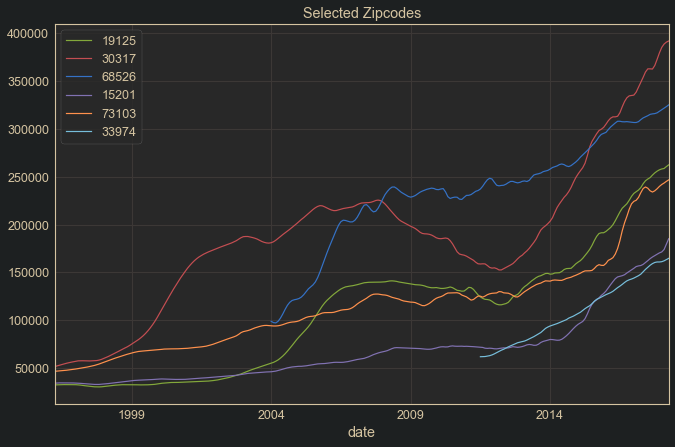

In [139]:
# So there we have it, a list of 6 zip codes which meet all of our investment criteria.
# Let's look at them together
for zipcode in best_selections.index:
    grp = groups.get_group(zipcode)
    grp.set_index('date').value.plot(label=zipcode)
plt.title('Selected Zipcodes')
plt.legend();

In [ ]:
# Of the above 6, the 30317 Atlanta zip code looks to be the most risky investment. It is 
# more volatile than the others, and may be approaching an overvalued state. Since we already
# have enough urban zip codes in our list, we will drop this one.
best_selections.drop(index=[30317], inplace=True)

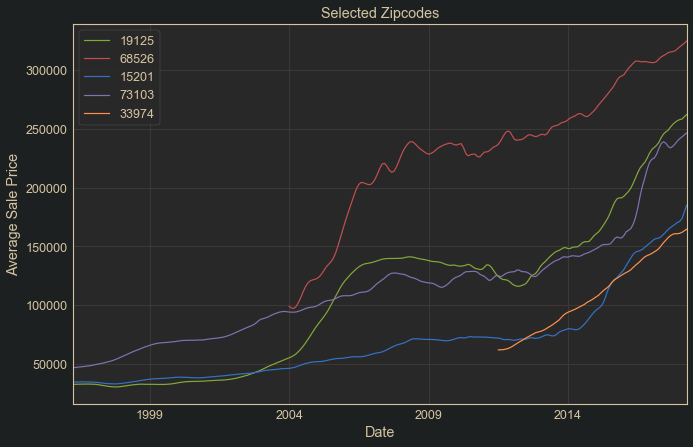

In [189]:
for zipcode in best_selections.index:
    grp = groups.get_group(zipcode)
    grp.set_index('date').value.plot(label=zipcode)
plt.title('Selected Zipcodes')
plt.ylabel('Average Sale Price')
plt.xlabel('Date')
plt.legend();

In [142]:
best_selections

City State          Metro    CountyName  avg_return  \
zipcode                                                                 
19125     Philadelphia    PA   Philadelphia  Philadelphia    0.011195   
68526          Lincoln    NE        Lincoln     Lancaster    0.004528   
15201       Pittsburgh    PA     Pittsburgh     Allegheny    0.016459   
73103    Oklahoma City    OK  Oklahoma City      Oklahoma    0.010975   
33974     Lehigh Acres    FL     Fort Myers           Lee    0.010976   

         national_avg_return    P2R  national_p2r_avg  
zipcode                                                
19125               0.004491  11.20             11.44  
68526               0.004491  10.45             11.44  
15201               0.004491  10.46             11.44  
73103               0.004491  10.57             11.44  
33974               0.004491  10.80             11.44

In [143]:
# Exporting our list for use in modeling later
best_selections.to_csv('data/top_five_zips.csv')

### Conclusions:
From this analysis of various zip codes in their relative performances in returns over various time frames, as well as their locations, their Price-to-Rent ratios, and other availiable information, we have narrowed down our interest to 5 zip codes worthy of investment:

1. 19125 - Philadelphia, PA
2. 68526 - Lincoln, NE
3. 15201 - Pittsburgh, PA
4. 73103 - Oklahoma City, OK
5. 33974 - Lehigh Acres, FL

<a id='whole_market'></a>
## Looking at the whole real estate market within the data
Since there are so many individual zipcodes, it will be useful to do some investigation with a more broad view by taking the average of the median sale prices of all the zipcodes for each month. This will give us an overall view of what generally happened with the market over the time period.

Median for 1996-04: 99500.0
Mean for 1996-04: 118299.12306343175
Normality Test Results for ['1996-04']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-04 
 Statistic 
 1.0 
 0.669048 
 
 
 p-value 
 0.0 
 0.000000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-04 
 704.744235 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-04 
 
 
 
 
 Statistic 
 3.184048e+07 
 
 
 p-value 
 0.000000e+00 
 
 
 Skew 
 8.186575e+00 
 
 
 Kurtosis 
 2.387458e+02

Median for 1996-05: 99500.0
Mean for 1996-05: 118419.0441391406
Normality Test Results for ['1996-05']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-05 
 Statistic 
 1.0 
 0.667243 
 
 
 p-value 
 0.0 
 0.000000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-05 
 709.007375 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-05 
 
 
 
 
 Statistic 
 3.321174e+07 
 
 
 p-value 
 0.000000e+00 
 
 
 Skew 
 8.277905e+00 
 
 
 Kurtosis 
 2.437801e+02

Median for 1996-06: 99700.0
Mean for 1996-06: 118537.42326805028
Normality Test Results for ['1996-06']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-06 
 Statistic 
 1.0 
 0.665485 
 
 
 p-value 
 0.0 
 0.000000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-06 
 713.330173 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-06 
 
 
 
 
 Statistic 
 3.449232e+07 
 
 
 p-value 
 0.000000e+00 
 
 
 Skew 
 8.362241e+00 
 
 
 Kurtosis 
 2.483884e+02

Median for 1996-07: 99700.0
Mean for 1996-07: 118653.06927798889
Normality Test Results for ['1996-07']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-07 
 Statistic 
 1.0 
 0.66371 
 
 
 p-value 
 0.0 
 0.00000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-07 
 717.804874 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-07 
 
 
 
 
 Statistic 
 3.577506e+07 
 
 
 p-value 
 0.000000e+00 
 
 
 Skew 
 8.445455e+00 
 
 
 Kurtosis 
 2.529192e+02

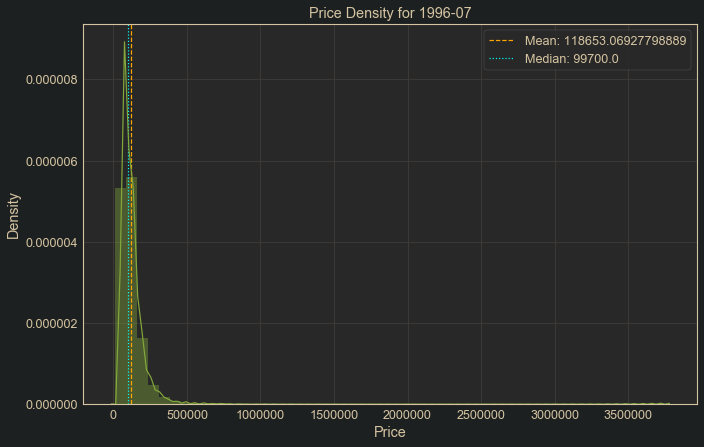

Median for 1996-08: 99800.0
Mean for 1996-08: 118780.25431160479
Normality Test Results for ['1996-08']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-08 
 Statistic 
 1.0 
 0.661852 
 
 
 p-value 
 0.0 
 0.000000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-08 
 722.401212 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-08 
 
 
 
 
 Statistic 
 3.718596e+07 
 
 
 p-value 
 0.000000e+00 
 
 
 Skew 
 8.534637e+00 
 
 
 Kurtosis 
 2.578099e+02

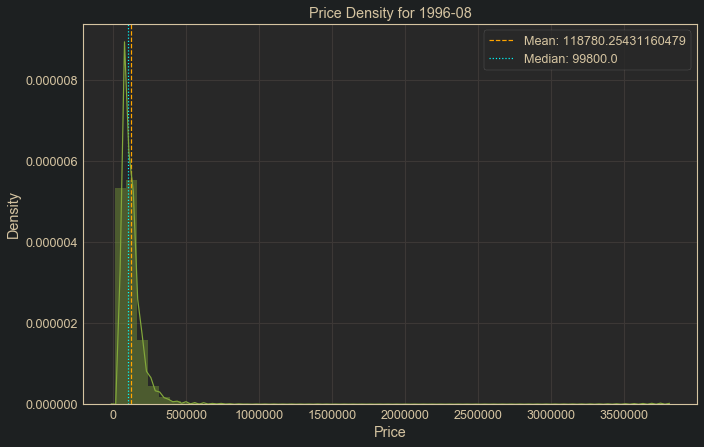

In [144]:
# Checking to see if mean is a reliable statistic:
datezips = df.set_index('zipcode').drop(columns=['City', 'State', 'Metro', 'CountyName'])
for i in range(5):
    subset = datezips.iloc[:, i].dropna()
    fig, ax = plt.subplots()
    ax.axvline(subset.mean(), ls='--', c='orange', label='Mean: {}'.format(subset.mean()))
    ax.axvline(subset.median(), ls=':', c='cyan', label='Median: {}'.format(subset.median()))
    sns.distplot(subset)
    print("Median for {}: {}".format(subset.name, subset.median()))
    print("Mean for {}: {}".format(subset.name, subset.mean()))
    mf.check_normality(subset, [subset.name])
    plt.title('Price Density for {}'.format(datezips.columns[i]))
    plt.xlabel('Price')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

Median for 1996-04: 11.507912923146684
Mean for 1996-04: 11.514263656083454
Normality Test Results for ['1996-04']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-04 
 Statistic 
 1.0 
 9.964508e-01 
 
 
 p-value 
 0.0 
 1.173114e-17 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-04 
 5.471796 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-04 
 
 
 
 
 Statistic 
 2.592146e+02 
 
 
 p-value 
 5.155377e-57 
 
 
 Skew 
 1.697598e-01 
 
 
 Kurtosis 
 3.582543e+00

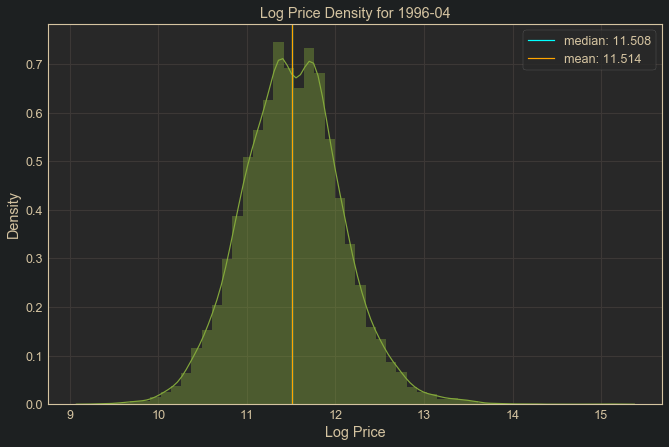

Median for 1996-05: 11.507912923146684
Mean for 1996-05: 11.515620114910819
Normality Test Results for ['1996-05']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-05 
 Statistic 
 1.0 
 9.963446e-01 
 
 
 p-value 
 0.0 
 5.902393e-18 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-05 
 5.646196 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-05 
 
 
 
 
 Statistic 
 2.680339e+02 
 
 
 p-value 
 6.268676e-59 
 
 
 Skew 
 1.748670e-01 
 
 
 Kurtosis 
 3.589732e+00

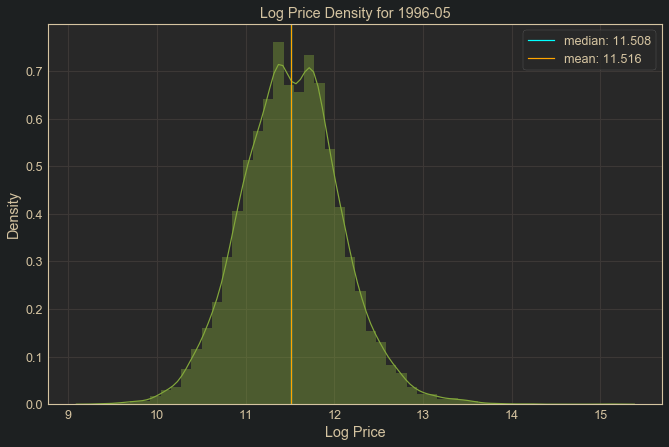

Median for 1996-06: 11.50992095594993
Mean for 1996-06: 11.516948575182408
Normality Test Results for ['1996-06']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-06 
 Statistic 
 1.0 
 9.962552e-01 
 
 
 p-value 
 0.0 
 3.346901e-18 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-06 
 5.833936 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-06 
 
 
 
 
 Statistic 
 2.773738e+02 
 
 
 p-value 
 5.875499e-61 
 
 
 Skew 
 1.800722e-01 
 
 
 Kurtosis 
 3.597306e+00

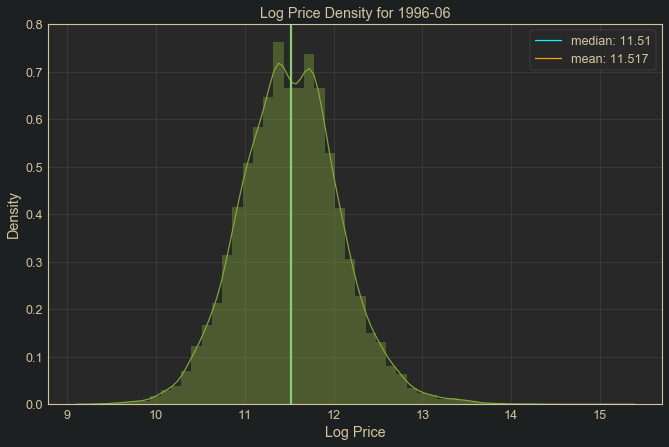

Median for 1996-07: 11.50992095594993
Mean for 1996-07: 11.518235757662946
Normality Test Results for ['1996-07']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-07 
 Statistic 
 1.0 
 9.961358e-01 
 
 
 p-value 
 0.0 
 1.591792e-18 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-07 
 6.034485 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-07 
 
 
 
 
 Statistic 
 2.870832e+02 
 
 
 p-value 
 4.577968e-63 
 
 
 Skew 
 1.854644e-01 
 
 
 Kurtosis 
 3.604913e+00

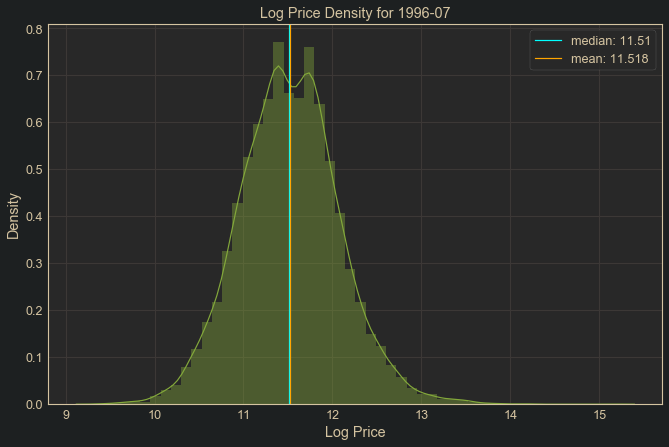

Median for 1996-08: 11.510923462299555
Mean for 1996-08: 11.519575746755715
Normality Test Results for ['1996-08']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-08 
 Statistic 
 1.0 
 9.960376e-01 
 
 
 p-value 
 0.0 
 8.740750e-19 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-08 
 6.244039 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-08 
 
 
 
 
 Statistic 
 2.970940e+02 
 
 
 p-value 
 3.067993e-65 
 
 
 Skew 
 1.905442e-01 
 
 
 Kurtosis 
 3.613055e+00

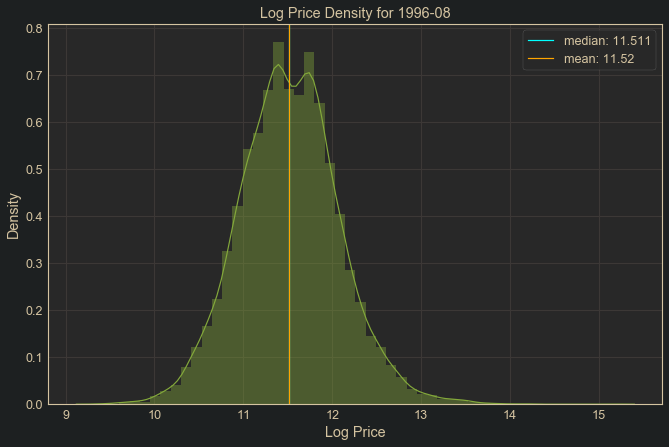

In [145]:
# We can see the prices among the zipcodes for each month are heavily positively skewed,
# log transformations may help this, but it may be more appropriate to use median values.
# Looking at the effect of log transformations:
for i in range(5):
    fig, ax = plt.subplots()
    subset = np.log(datezips.iloc[:, i])
    sns.distplot(subset.dropna(), ax=ax)
    median = subset.median()
    mean = subset.mean()
    print("Median for {}: {}".format(subset.name, median))
    print("Mean for {}: {}".format(subset.name, mean))
    mf.check_normality(subset, [subset.name])
    ax.axvline(median, color='cyan', label='median: {}'.format(round(median, 3)))
    ax.axvline(mean, color='orange', label='mean: {}'.format(round(mean, 3)))
    plt.title('Log Price Density for {}'.format(datezips.columns[i]))
    plt.xlabel('Log Price')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [146]:
# It looks as though the log transformations have made the prices for each zip code
# per month much more normal. The tests are still rejecting the null-hypothesis of normality,
# but as the warnings above make clear, this may be (and probably is) due to the very large
# sample size of 14k+ zip codes. Looking at the median and means from this, we can see that
# they are all very similar, meaning the distribution is centered, also indicated by the
# relatively low skew. We will use these logged distributions to represent each date, and take
# the means to track the changes of the market over time. In order to avoid artifacts in the 
# returns stream, we must leave out any zipcodes which had incomplete data over the time window
# of the dataset, which we can do by omitting any zipcodes found in the counts dictionary.

In [147]:
# Getting a series of means for each month
means = np.log(df.set_index('zipcode').drop(columns=['City', 'State', 'Metro', 'CountyName'])).mean()
means

1996-04    11.514264
1996-05    11.515620
1996-06    11.516949
1996-07    11.518236
1996-08    11.519576
             ...    
2017-12    12.244559
2018-01    12.249051
2018-02    12.254503
2018-03    12.262258
2018-04    12.268095
Length: 265, dtype: float64

In [148]:
# Making a series of means which omits zip codes that had missing data:
means_clean = np.log(df.set_index('zipcode').drop(columns=['City', 'State', 'Metro', 'CountyName'],
                                      index=counts.keys()
                                     )).mean()
means_clean

1996-04    11.514264
1996-05    11.515620
1996-06    11.516949
1996-07    11.518236
1996-08    11.519576
             ...    
2017-12    12.279193
2018-01    12.283881
2018-02    12.289423
2018-03    12.297175
2018-04    12.303019
Length: 265, dtype: float64

In [150]:
# Setting index to datetime format and checking result
means.index = pd.to_datetime(means.index, format='%Y-%m')
means_clean.index = pd.to_datetime(means_clean.index, format='%Y-%m')
means.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [152]:
means = pd.DataFrame(means)
means.columns = ['mean price']
means.head()

mean price
1996-04-01   11.514264
1996-05-01   11.515620
1996-06-01   11.516949
1996-07-01   11.518236
1996-08-01   11.519576

In [153]:
means_clean = pd.DataFrame(means_clean)
means_clean.columns = ['mean log price']
means_clean.head()

mean log price
1996-04-01       11.514264
1996-05-01       11.515620
1996-06-01       11.516949
1996-07-01       11.518236
1996-08-01       11.519576

In [154]:
means.plot(style='.b', figsize=(11,7))
plt.title("Mean log sale price across all zipcodes over time")
plt.xlabel("Date")
plt.ylabel("Mean Price")
plt.show()

means.diff().plot(figsize=(11,7))
plt.title('Log returns')
plt.xlabel('Date')
plt.ylabel('log returns')
plt.show()

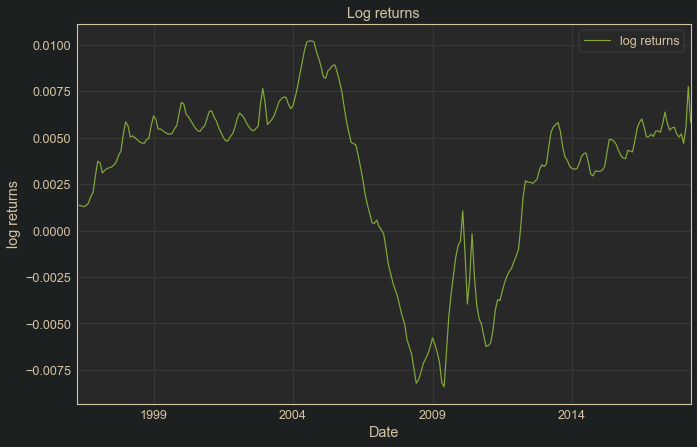

In [155]:
means_clean.plot(style='.b', figsize=(11,7))
plt.title("Mean sale price across all zipcodes without NaN values over time")
plt.xlabel("Date")
plt.ylabel("Mean Log Price")
plt.show()

means_clean.diff().plot(figsize=(11,7))
plt.title('Log returns')
plt.xlabel('Date')
plt.ylabel('log returns')
plt.legend(['log returns'])
plt.show()

We can see that not omitting the zip codes with incomplete data introduces more noise, and more extreme volatility on certain months. This would have had adverse effects on modeling, and made us see features in the data that were actually just artifacts of new zipcodes poppping up along the timeline.<br>
<br>
We can definitely see an overall trend in the data. It is a reminder that the housing market crashed in the [Subprime Mortgage Crisis](https://en.wikipedia.org/wiki/Subprime_mortgage_crisis) between 2007 and 2010, due to too many subprime mortgages being written out by banks (which they then sold on the securities market), many of which were ultimately foreclosed on. After the dip, we see another period of price inflation, but can we expect to see another "bubble pop" in another 5 years or so? That would have to consider whether the circumstances that led to the 2008 crash were truly unique, or whether there is a cyclic period of deflation that is known to happen even without questionable banking practices occuring in a widespread fashion. More historical data would be helpful to look for such a recurring trend, but is not available in the dataset. Another important consideration is that the data only goes through April of 2018, and that it is currently the end of July 2020, so the pattern may already be changing, if only we had more data to show it.<br>
<br>
Turning to outside research, an <a href='https://www.investopedia.com/investing/next-housing-recession-2020-predicts-zillow/'>article</a> posted in investopedia.com on October 2, 2019, states that researchers at Zillow (the same company that provided the data being used) predicted the next housing recession would manifest itself in 2020, though not for the same reasons as the 2008 crash. Their concerns were instead focused on rising federal interest rates, which would lead to mortgages being more expensive for potential homebuyers, potentially driving them out of the market. The article mentioned that very low unemployment, steady economic growth, and limited housing supply were overshadowing those concerns at the time of the research.<br>
<br>
There are some important things to mention in response to this. First is that around the time the article was written, the fed began to reduce interest rates. Then, in 2020, the Covid-19 pandemic struck and the federal interest rates plummeted to 0.25%, whereas they had been close to 2% when the article was published. This can be seen in the chart below:

<u>Historic Fed Interest Rates:</u>
![Historic Fed Interest Rates](images/fed_rates_chart.png)

This would mean that interest rates will likely not be the leading factor in a housing market recession, if it were to happen this year. Instead, vast unemployment and financial hardship due to the virus will be likely to drive housing prices down. Thus, though the reasoning may be different, it is not unlikely to see a declining housing market in 2020. This is another good reason to determine the zipcodes which were most resilient during the last downturn.<br>
<br>
A more recent <a href=https://www.redfin.com/blog/charting-coronavirus-housing-market-trends/>article</a> posted on Redfin.com corroborates the theory of another downturn occurring due to the pandemic. It shows that year-on-year price growth has indeed stagnated amidst the Covid-19 pandemic. The article mentions that lagged competition has given buyers more room to negotiate better prices, but stresses that sellers are not yet willing to reduce prices, knowing that supply is still low. This is summed up in a quote from Redfin agent David Palmer: "There’s fear on both sides. We have a bunch of buyers who want 40,000 dollar price reductions or credit that really should have been 15,000 dollars to 20,000 dollars. We’re calling it the ‘coronavirus credit’. I’d say it is getting a little closer to a level playing field, but sellers know that inventory is low and they’re trying to stick to their guns."

A further update to this line of thinking is the current eviction crisis. Homeowners may be looking to sell properties if they cannot find stable tenants to occupy them during the crisis, and this may lead to a surplus in supply, and a decrease in demand, leading to lower prices over the next year at least.<br>
<br>
All of this being said, all we should really keep in mind is that market downturns do occur, and usually for reasons unforseen to investors. Since the dataset only spans to April 2018, we should imagine that we are consulting investors at that time, so that none of our knowledge of current events in 2020 introduces look-ahead bias into this project. From now on, we will pretend we are living in mid-2018.

In [95]:
# exporting .csv file of means for use in R notebook:
# Note that this was exported before I realized that I made the mistake of analyzing the data
# with the artifacts from the presence of zipcodes with incomplete data. You can see the false
# conclusions that I came to in doing so in other notebooks
means.to_csv('data/housing_means.csv')

In [156]:
# exporting the corrected means
means_clean.to_csv('data/housing_means_clean.csv')

In [157]:
# Since we no longer need the tainted means, I will reinstantiate so that the corrected means
# are known as 'means'
means = means_clean

### Checking Stationarity

Text(0.5, 1.0, 'Differenced means across all zipcodes')

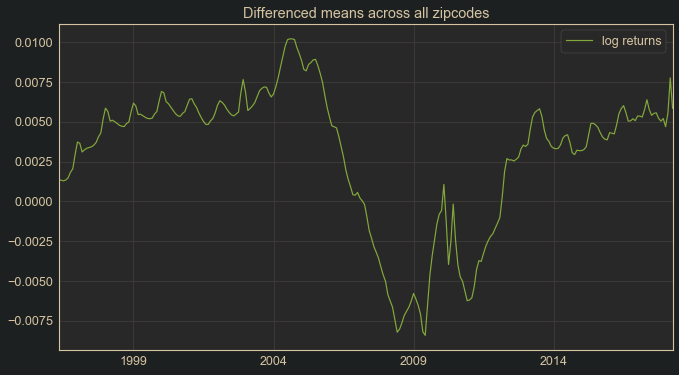

In [158]:
# Looking at the log returns (the differenced log values), we can see that the series is not
# stationary, as the mean is not constant, and clearly displays a trend.
means_diff = means.diff().dropna()
means_diff.columns = ['log returns']
means_diff.plot(figsize=(11,6))
plt.title("Differenced means across all zipcodes")

In [159]:
# After differencing, we can still see the large trend caused by the crash and recovery of the
# market. Also, we can see what may be yearly seasonality starting to appear

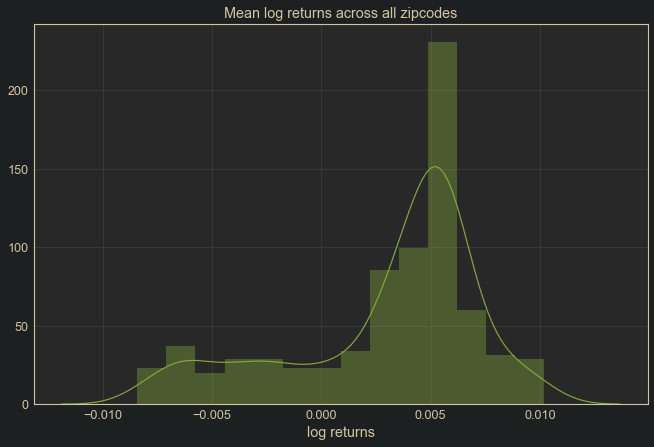

In [160]:
# We can see that these values are not normally distributed
sns.distplot(means_diff['log returns'])
plt.title("Mean log returns across all zipcodes");

In [162]:
# Showing the corresponding percentage to a log return of .005, representing a .5% gain
np.exp(0.005)

1.005012520859401

In [165]:
# We can see that by and large, investors in the market had positive returns on a monthly basis
# Let's see what a Dickey-Fuller test would have to say about the stationarity of this series.

# Using Dickey-Fuller test on stationarity of log returns
dftest = adfuller(means_diff['log returns'])
dfoutput = pd.DataFrame(dftest[0:4], 
                        index=['Test Statistic',
                               'p-value', 
                               '#Lags Used', 
                               'Number of Observations Used'],
                        columns=['Dickey-Fuller']
                       )
dfoutput

Dickey-Fuller
Test Statistic                   -1.942736
p-value                           0.312231
#Lags Used                       14.000000
Number of Observations Used     249.000000

In [166]:
#di.export(dfoutput, 'images/adfoutput_returns.png')

In [167]:
# Above we can see that differencing the log means has not made them stationary according to the
# Augmented Dickey-Fuller test, as the null hypothesis of non-stationarity has not been
# rejected. Let's see if further transformations or differencing will fix it

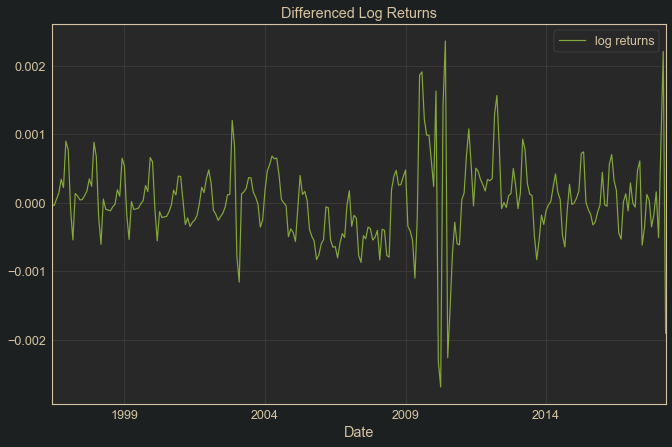

In [168]:
# Since the d value in ARIMA models does not represent the number of periods to difference
# across, but rather how many times a difference of 1 period is done recursively, I would like
# to see what a 2nd order differencing would do for the data.
# Since log returns are the first order difference of the log values of a price series, we
# will make a series log_returns, then perform another order of differencing. This will amount
# to two orders of differencing on the original series.
log_returns = means.diff().dropna()
log_returns.columns = ['log returns']
log_returns = log_returns.asfreq('MS')
diff_log_returns = log_returns.diff().dropna()
diff_log_returns.plot()
plt.title('Differenced Log Returns')
plt.xlabel('Date')
plt.show()

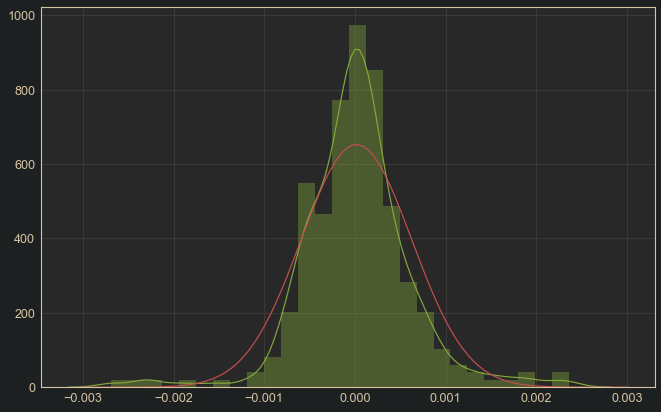

In [169]:
# This is looking much more stationary, let's see the distribution compared to a normal dist
fig, ax = plt.subplots()
sns.distplot(diff_log_returns, ax=ax)
xx = np.linspace(-.003, .003, 100)
yy = stats.norm.pdf(xx, loc=diff_log_returns.mean(), scale=diff_log_returns.std())
ax.plot(xx, yy)

In [170]:
dftest = adfuller(diff_log_returns)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print("Dickey-Fuller Results for Differenced Means:\n================================\n",dfoutput)

Dickey-Fuller Results for Differenced Means:
 Test Statistic                  -3.509216
p-value                          0.007754
#Lags Used                      13.000000
Number of Observations Used    249.000000
dtype: float64


In [171]:
# Using Dickey-Fuller test on stationarity of log returns
dftest = adfuller(diff_log_returns)
dfoutput = pd.DataFrame(dftest[0:4], 
                        index=['Test Statistic',
                               'p-value', 
                               '#Lags Used', 
                               'Number of Observations Used'],
                        columns=['Dickey-Fuller']
                       )
dfoutput

Dickey-Fuller
Test Statistic                   -3.509216
p-value                           0.007754
#Lags Used                       13.000000
Number of Observations Used     249.000000

In [172]:
#di.export(dfoutput, 'images/adfoutput_diff_returns.png')

In [173]:
# We can see that this second order of differencing has made for a much more normal, and much
# more stationary series. Although there is still visibile volatility clustering, it may be
# sufficient to try some modeling.

It is worth noting at this point that the ADF test rejected the null hypothesis of non-stationarity, but this is misleading, because one of the requirements of a stationary time series is having constant variance across time. As cited in [Stockhammar & Oller (2007)](https://www.diva-portal.org/smash/get/diva2:187599/FULLTEXT01.pdf), a study by Kim and Schmidt (1993) showed that Dickey-Fuller tests tend to reject too often in the presence of conditional heteroscedasticity (pg. 4). In order for a time series to be considered weakly stationary, which is an assumption for ARIMA models, it must have constant mean AND variance. As Stockhammar and Oller go on to discuss in their paper, conditional heteroskedasticity can make it difficult to detect time-varying means, masking non-stationarity. This means that the non-stationarity in variance must be dealt with, or omitted from the data in order to meet the assumptions of ARIMA models.

### Considering Returns Instead
Upon further reading on modeling financial markets, it has come to my attention that people generally model returns rather than the prices, because these tend to more closely resemble normal distributions, and have better stationarity. Further, returns are generally calculated in practice as log returns, due to their additive properties. When returns are represented as percentages, they are multiplicative of their previous value, whereas log returns can be added together rather than multiplied. This make for more convenient math considering sequential data, since a cumsum() method can combine all of the growth.

### Looking at Seasonal Decomposition

I'd like to see what the seasonal_decompose function does with this data.

In [175]:
log_returns = means['mean log price'].diff().dropna()
log_returns.name = 'log returns'

In [176]:
log_returns.head()

1996-05-01    0.001356
1996-06-01    0.001328
1996-07-01    0.001287
1996-08-01    0.001340
1996-09-01    0.001482
Name: log returns, dtype: float64

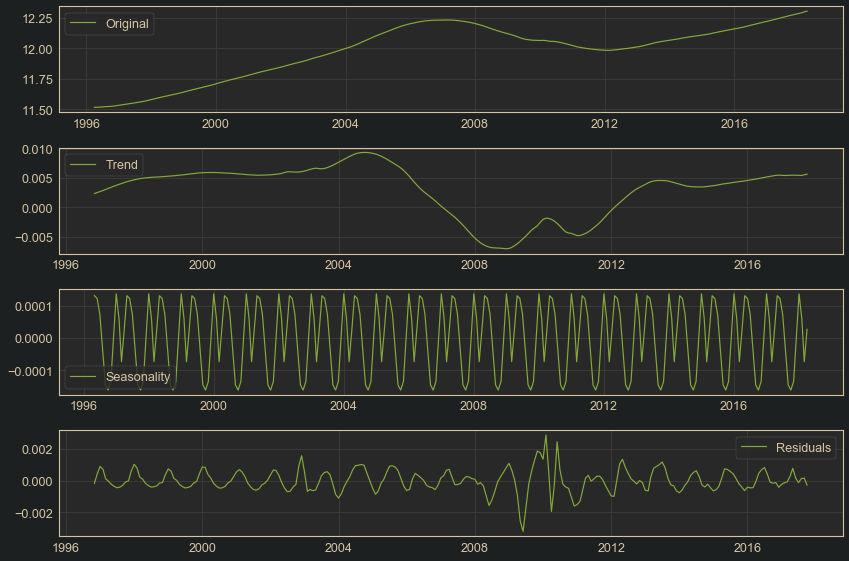

In [177]:
decomposition = seasonal_decompose(log_returns)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(means.dropna(), label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [178]:
# We can see that when the decomposition removes the large sweeping trend
# This decomposition seems to be detecting yearly seasonality as well, but it is very
# small in influence
# The residuals show some heteroscedasticity, but mostly they seem pretty consistent

### Using Periodogram to find long-term seasonality

I would now like to see if a periodogram can detect some longer seasonal trends

In [179]:
from scipy.signal import periodogram

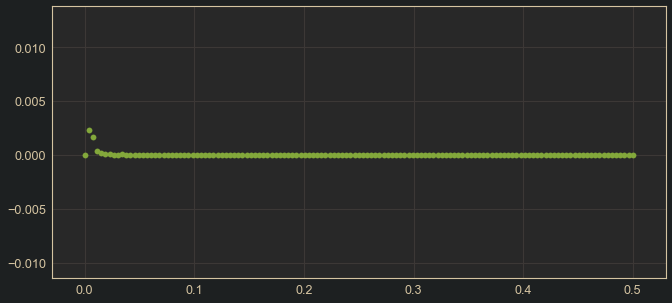

In [180]:
pgram = periodogram(log_returns)
plt.figure(figsize=(11,5))
plt.scatter(pgram[0], pgram[1]);

In [181]:
# Finding 3 largest specs:
indices = np.argpartition(pgram[1], -2)[-3:]
pd.DataFrame(list(zip((1 / pgram[0][indices])[::-1], pgram[1][indices][::-1])),
             columns=['Period', 'Spec']
            )

Period      Spec
0   264.0  0.002350
1   132.0  0.001705
2    88.0  0.000388

In [182]:
# check length of log_returns
print(len(log_returns))
print(len(log_returns)/2)
print(len(log_returns)/3)

264
132.0
88.0


We can see that the most influential periods from the periodogram are periods which correspond to the full length of the dataset, half the length of the dataset, and a third of the length of the dataset. As shown in the investigation in [this notebook](understanding_fourier_series_with_R.ipynb), this is merely an artifact of the math involved in the periodogram, and does not give us conclusive evidence of a long term seasonality. As was shown in the other notebook, a mostly random set of data will show spikes on a periodogram at the full length of the data, and another at the halfway point. It should be noted however that the strength of the spike at the half-period in this series is stronger than expected for random data.

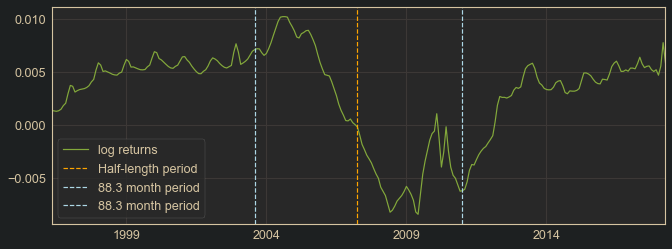

In [183]:
# Here we can observe visually the periods indicated by the periodogram, and see that there is
# no real seasonality at these periods:
ax = log_returns.plot(figsize=(11,4))
ax.axvline(means.index[132], 
           color='orange', 
           ls='--',
           label='Half-length period'
          )
ax.axvline(means.index[88], 
           color='lightblue', 
           ls='--',
           label='88.3 month period'
          )
ax.axvline(means.index[177], 
           color='lightblue', 
           ls='--',
           label='88.3 month period'
          )
plt.legend();

To drive this point home, the reason that a powerful spike will always be present at the period corresponding to the full length of a dataset is because you can take any time series of data, and lay it end on end some number of times, and produce a seasonality. This is shown below.

In [184]:
# Placing the trend data end on end
trend2 = pd.concat([pd.DataFrame(log_returns), 
                    pd.DataFrame(log_returns)], axis=0).reset_index()

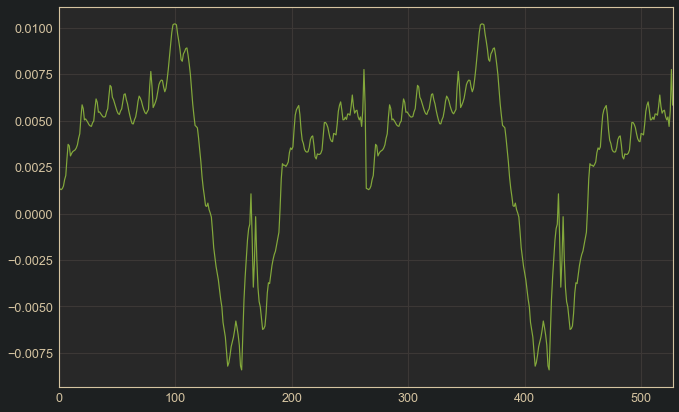

In [185]:
# Here we can see that having a seasonality the full length of data is not a valid assumption
# since repeating data is bound to make seasonality occur
trend2['log returns'].plot();

In [186]:
# Let's see if the seasonal component of the decomposition has useful information
pgram = periodogram(seasonal)
plt.figure(figsize=(11,5))
plt.scatter(pgram[0], pgram[1]);

In [187]:
# Finding 3 largest specs:
indices = np.argpartition(pgram[1], -2)[-3:]
pd.DataFrame(list(zip((1 / pgram[0][indices])[::-1], pgram[1][indices][::-1])),
             columns=['Period', 'Spec']
            )

Period          Spec
0     6.0  1.287000e-06
1    12.0  1.273207e-06
2     4.0  2.444789e-07

In [117]:
# We can see that there are factors of 12 (yearly seasonality) perhaps a fourier series from
# these values might help a model

In [195]:
dic = groups.groups
list(dic.keys())[-1]

99901